# WeRateDogs Analysis
## 1. Gather Data

In [314]:
import requests
import numpy as np
import pandas as pd
import io
import tweepy
import json
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
from IPython.core.display import Image, display
import urllib.request

### 1.1 WeRateDogs archive

Gather data from local csv file.

In [2]:
twitter_archive_df = pd.read_csv('../data/twitter-archive-enhanced.csv')

In [4]:
twitter_archive_df.shape

(2356, 17)

### 1.2 Dog breed prediction
Gather data from a URL with the requests library.

In [5]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [6]:
r.status_code

200

In [7]:
r.headers['content-type']

'text/tab-separated-values; charset=utf-8'

In [8]:
raw_data = r.content

In [257]:
prediction_df = pd.read_csv(io.StringIO(raw_data.decode('utf-8')), sep='\t')

In [259]:
# write tsv
prediction_df.to_csv('../data/image-predictions.tsv', sep='\t')
prediction_df.shape

(2075, 12)

### 1.3 Twitter like and retweet counts
Gather data via a twitter API. Key and tokens are removed.

In [12]:
consumer_key = 'XXXXXX'
consumer_secret = 'XXXXXX'
access_token ='XXXXXX'
access_token_secret = 'XXXXXX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


In [13]:
tweets = []
for tweet_id in list(twitter_archive_df['tweet_id']):
    try:
        tweet = api.get_status(tweet_id) #, tweet_mode='extended')
        tweets.append(tweet)
    except tweepy.TweepError as e:
        print(e.response.text)

{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status foun

Rate limit reached. Sleeping for: 69


{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}


In [150]:
len(tweets)

2337

In [151]:
# extract json content of every tweet into a list
my_list_of_dicts = []
for each_json_tweet in tweets:
    my_list_of_dicts.append(each_json_tweet._json)

In [152]:
# write every tweet's json into a txt file
with open('../data/tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [153]:
# extract the needed variables and convert it to a pandas dataframe
tweet_list = []
with open('../data/tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        text = each_dictionary['text']
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        created_at = each_dictionary['created_at']
        tweet_list.append({'tweet_id': str(tweet_id),
                             'text': str(text),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'created_at': created_at,
                            })
    tweet_json = pd.DataFrame(tweet_list, columns = 
                                  ['tweet_id', 'text', 
                                   'favorite_count', 'retweet_count', 
                                   'created_at'])

In [154]:
tweet_json.shape

(2337, 5)

In [21]:
# write dataframe to a csv file
tweet_json.to_csv('../data/tweet_dogs.csv', index=False)

In [260]:
# read tweet_dogs.csv (to avoid accessing the API every time)
tweets_df = pd.read_csv('../data/tweet_dogs.csv')

## 2. Assess Data

### 2.1 WeRateDogs archive

In [255]:
twitter_archive_df.head(2)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   

   rating_denominator     name doggo floofer pupper puppo  
0                  10  Phineas  None    None   None  None  
1                  10    Tilly  None    None   None  None

In [262]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [263]:
twitter_archive_df.describe()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03           7.800000e+01         7.800000e+01   
mean   7.427716e+17           7.455079e+17         2.014171e+16   
std    6.856705e+16           7.582492e+16         1.252797e+17   
min    6.660209e+17           6.658147e+17         1.185634e+07   
25%    6.783989e+17           6.757419e+17         3.086374e+08   
50%    7.196279e+17           7.038708e+17         4.196984e+09   
75%    7.993373e+17           8.257804e+17         4.196984e+09   
max    8.924206e+17           8.862664e+17         8.405479e+17   

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count         1.810000e+02              1.810000e+02       2356.000000   
mean          7.720400e+17              1.241698e+16         13.126486   
std           6.236928e+16              9.599254e+16         45.876648   
min           6.661041e+17              7.832140e+05          0.000000   
25%           7.186315e+17              4.196984e+09         10.000000   
50%           7.804657e+17              4.196984e+09         11.000000   
75%           8.203146e+17              4.196984e+09         12.000000   
max           8.874740e+17              7.874618e+17       1776.000000   

       rating_denominator  
count         2356.000000  
mean            10.455433  
std              6.745237  
min              0.000000  
25%             10.000000  
50%             10.000000  
75%             10.000000  
max            170.000000

In [268]:
# missings in variables
twitter_archive_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [347]:
#Check if every tweet id is unique and there are no duplicates.
twitter_archive_df['tweet_id'].nunique()
twitter_archive_df['tweet_id'].duplicated().any()

False

In [278]:
twitter_archive_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [345]:
# all tweets with denominator not 10:
twitter_archive_df[twitter_archive_df['rating_denominator'] != 10]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
313   835246439529840640           8.352460e+17         2.625958e+07   
342   832088576586297345           8.320875e+17         3.058208e+07   
433   820690176645140481                    NaN                  NaN   
516   810984652412424192                    NaN                  NaN   
784   775096608509886464                    NaN                  NaN   
902   758467244762497024                    NaN                  NaN   
1068  740373189193256964                    NaN                  NaN   
1120  731156023742988288                    NaN                  NaN   
1165  722974582966214656                    NaN                  NaN   
1202  716439118184652801                    NaN                  NaN   
1228  713900603437621249                    NaN                  NaN   
1254  710658690886586372                    NaN                  NaN   
1274  709198395643068416                    NaN                  NaN   
1351  704054845121142784                    NaN                  NaN   
1433  697463031882764288                    NaN                  NaN   
1598  686035780142297088           6.860340e+17         4.196984e+09   
1634  684225744407494656           6.842229e+17         4.196984e+09   
1635  684222868335505415                    NaN                  NaN   
1662  682962037429899265                    NaN                  NaN   
1663  682808988178739200           6.827884e+17         4.196984e+09   
1779  677716515794329600                    NaN                  NaN   
1843  675853064436391936                    NaN                  NaN   
2335  666287406224695296                    NaN                  NaN   

                      timestamp  \
313   2017-02-24 21:54:03 +0000   
342   2017-02-16 04:45:50 +0000   
433   2017-01-15 17:52:40 +0000   
516   2016-12-19 23:06:23 +0000   
784   2016-09-11 22:20:06 +0000   
902   2016-07-28 01:00:57 +0000   
1068  2016-06-08 02:41:38 +0000   
1120  2016-05-13 16:15:54 +0000   
1165  2016-04-21 02:25:47 +0000   
1202  2016-04-03 01:36:11 +0000   
1228  2016-03-27 01:29:02 +0000   
1254  2016-03-18 02:46:49 +0000   
1274  2016-03-14 02:04:08 +0000   
1351  2016-02-28 21:25:30 +0000   
1433  2016-02-10 16:51:59 +0000   
1598  2016-01-10 04:04:10 +0000   
1634  2016-01-05 04:11:44 +0000   
1635  2016-01-05 04:00:18 +0000   
1662  2016-01-01 16:30:13 +0000   
1663  2016-01-01 06:22:03 +0000   
1779  2015-12-18 05:06:23 +0000   
1843  2015-12-13 01:41:41 +0000   
2335  2015-11-16 16:11:11 +0000   

                                                 source  \
313   <a href="http://twitter.com/download/iphone" r...   
342   <a href="http://twitter.com/download/iphone" r...   
433   <a href="http://twitter.com/download/iphone" r...   
516   <a href="http://twitter.com/download/iphone" r...   
784   <a href="http://twitter.com/download/iphone" r...   
902   <a href="http://twitter.com/download/iphone" r...   
1068  <a href="http://twitter.com/download/iphone" r...   
1120  <a href="http://twitter.com/download/iphone" r...   
1165  <a href="http://twitter.com/download/iphone" r...   
1202  <a href="http://twitter.com/download/iphone" r...   
1228  <a href="http://twitter.com/download/iphone" r...   
1254  <a href="http://twitter.com/download/iphone" r...   
1274  <a href="http://twitter.com/download/iphone" r...   
1351  <a href="http://twitter.com/download/iphone" r...   
1433  <a href="http://twitter.com/download/iphone" r...   
1598  <a href="http://twitter.com/download/iphone" r...   
1634  <a href="http://twitter.com/download/iphone" r...   
1635  <a href="http://twitter.com/download/iphone" r...   
1662  <a href="http://twitter.com/download/iphone" r...   
1663  <a href="http://twitter.com/download/iphone" r...   
1779  <a href="http://twitter.com/download/iphone" r...   
1843  <a href="http://twitter.com/download/iphone" r...   
2335  <a href="http://twitter.com/download/iphone" r...   

                             

In [277]:
twitter_archive_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [284]:
twitter_archive_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [279]:
twitter_archive_df['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [280]:
twitter_archive_df['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [281]:
twitter_archive_df['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [282]:
twitter_archive_df['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [294]:
twitter_archive_df['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Oliver        11
Lucy          11
Tucker        10
Penny         10
Lola          10
Bo             9
Winston        9
Sadie          8
the            8
Daisy          7
Bailey         7
an             7
Buddy          7
Toby           7
Koda           6
Jack           6
Dave           6
Leo            6
Bella          6
Jax            6
Rusty          6
Scout          6
Oscar          6
Stanley        6
Milo           6
Oakley         5
            ... 
Bradlay        1
Tove           1
Kellogg        1
Tuck           1
Bookstore      1
Monty          1
Chaz           1
Finnegus       1
Lipton         1
DonDon         1
Marlee         1
Covach         1
Emma           1
Nida           1
Fiji           1
Dotsy          1
Olaf           1
Henry          1
Sunshine       1
Jangle         1
Kathmandu      1
Rilo           1
Pilot          1
Sora           1
Ben            1
Marty          1
Kevon          1
Alexander     

In [297]:
# tweets where there is a reply to status (column is not null)
twitter_archive_df[~twitter_archive_df['in_reply_to_status_id'].isnull()]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
30    886267009285017600           8.862664e+17         2.281182e+09   
55    881633300179243008           8.816070e+17         4.738443e+07   
64    879674319642796034           8.795538e+17         3.105441e+09   
113   870726314365509632           8.707262e+17         1.648776e+07   
148   863427515083354112           8.634256e+17         7.759620e+07   
149   863079547188785154           6.671522e+17         4.196984e+09   
179   857214891891077121           8.571567e+17         1.806710e+08   
184   856526610513747968           8.558181e+17         4.196984e+09   
186   856288084350160898           8.562860e+17         2.792810e+08   
188   855862651834028034           8.558616e+17         1.943518e+08   
189   855860136149123072           8.558585e+17         1.361572e+07   
218   850333567704068097           8.503288e+17         2.195506e+07   
228   848213670039564288           8.482121e+17         4.196984e+09   
234   847617282490613760           8.476062e+17         4.196984e+09   
251   844979544864018432           7.590995e+17         4.196984e+09   
274   840698636975636481           8.406983e+17         8.405479e+17   
290   838150277551247360           8.381455e+17         2.195506e+07   
291   838085839343206401           8.380855e+17         2.894131e+09   
313   835246439529840640           8.352460e+17         2.625958e+07   
342   832088576586297345           8.320875e+17         3.058208e+07   
346   831926988323639298           8.319030e+17         2.068372e+07   
387   826598799820865537           8.265984e+17         4.196984e+09   
409   823333489516937216           8.233264e+17         1.582854e+09   
427   821153421864615936           8.211526e+17         1.132119e+08   
498   813130366689148928           8.131273e+17         4.196984e+09   
513   811647686436880384           8.116272e+17         4.196984e+09   
565   802265048156610565           7.331095e+17         4.196984e+09   
570   801854953262350336           8.018543e+17         1.185634e+07   
576   800859414831898624           8.008580e+17         2.918590e+08   
611   797165961484890113           7.971238e+17         2.916630e+07   
...                  ...                    ...                  ...   
1479  693582294167244802           6.935722e+17         1.198989e+09   
1497  692423280028966913           6.924173e+17         4.196984e+09   
1501  692142790915014657           6.920419e+17         4.196984e+09   
1523  690607260360429569           6.903413e+17         4.670367e+08   
1598  686035780142297088           6.860340e+17         4.196984e+09   
1605  685681090388975616           6.855479e+17         4.196984e+09   
1618  684969860808454144           6.849598e+17         4.196984e+09   
1630  684538444857667585           6.844811e+17         4.196984e+09   
1634  684225744407494656           6.842229e+17         4.196984e+09   
1663  682808988178739200           6.827884e+17         4.196984e+09   
1689  681340665377193984           6.813394e+17         4.196984e+09   
1774  678023323247357953           6.780211e+17         4.196984e+09   
1819  676590572941893632           6.765883e+17         4.196984e+09   
1842  675870721063669760           6.757073e+17         4.196984e+09   
1844  675849018447167488           6.758457e+17         4.196984e+09   
1852  675707330206547968           6.754971e+17         4.196984e+09   
1866  675349384339542016           6.749998e+17         4.196984e+09   
1882  674999807681908736           6.747934e+17         4.196984e+09   
1885  674793399141146624           6.717299e+17         4.196984e+09   
1892  674754018082705410           6.747522e+17         4.196984e+09   
1895  674742531037511680           6.747400e+17         4.196984e+09   
1905  674606911342424069           6.744689e+17         4.196984e+09   
1914  674330906434379776           6.658147e+17         1.637468e+07   
1940  673716320723169284           6.737159e+17         

In [337]:
# tweets where there is a reply to user (column is not null)
twitter_archive_df[~twitter_archive_df['in_reply_to_user_id'].isnull()]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
30    886267009285017600           8.862664e+17         2.281182e+09   
55    881633300179243008           8.816070e+17         4.738443e+07   
64    879674319642796034           8.795538e+17         3.105441e+09   
113   870726314365509632           8.707262e+17         1.648776e+07   
148   863427515083354112           8.634256e+17         7.759620e+07   
149   863079547188785154           6.671522e+17         4.196984e+09   
179   857214891891077121           8.571567e+17         1.806710e+08   
184   856526610513747968           8.558181e+17         4.196984e+09   
186   856288084350160898           8.562860e+17         2.792810e+08   
188   855862651834028034           8.558616e+17         1.943518e+08   
189   855860136149123072           8.558585e+17         1.361572e+07   
218   850333567704068097           8.503288e+17         2.195506e+07   
228   848213670039564288           8.482121e+17         4.196984e+09   
234   847617282490613760           8.476062e+17         4.196984e+09   
251   844979544864018432           7.590995e+17         4.196984e+09   
274   840698636975636481           8.406983e+17         8.405479e+17   
290   838150277551247360           8.381455e+17         2.195506e+07   
291   838085839343206401           8.380855e+17         2.894131e+09   
313   835246439529840640           8.352460e+17         2.625958e+07   
342   832088576586297345           8.320875e+17         3.058208e+07   
346   831926988323639298           8.319030e+17         2.068372e+07   
387   826598799820865537           8.265984e+17         4.196984e+09   
409   823333489516937216           8.233264e+17         1.582854e+09   
427   821153421864615936           8.211526e+17         1.132119e+08   
498   813130366689148928           8.131273e+17         4.196984e+09   
513   811647686436880384           8.116272e+17         4.196984e+09   
565   802265048156610565           7.331095e+17         4.196984e+09   
570   801854953262350336           8.018543e+17         1.185634e+07   
576   800859414831898624           8.008580e+17         2.918590e+08   
611   797165961484890113           7.971238e+17         2.916630e+07   
...                  ...                    ...                  ...   
1479  693582294167244802           6.935722e+17         1.198989e+09   
1497  692423280028966913           6.924173e+17         4.196984e+09   
1501  692142790915014657           6.920419e+17         4.196984e+09   
1523  690607260360429569           6.903413e+17         4.670367e+08   
1598  686035780142297088           6.860340e+17         4.196984e+09   
1605  685681090388975616           6.855479e+17         4.196984e+09   
1618  684969860808454144           6.849598e+17         4.196984e+09   
1630  684538444857667585           6.844811e+17         4.196984e+09   
1634  684225744407494656           6.842229e+17         4.196984e+09   
1663  682808988178739200           6.827884e+17         4.196984e+09   
1689  681340665377193984           6.813394e+17         4.196984e+09   
1774  678023323247357953           6.780211e+17         4.196984e+09   
1819  676590572941893632           6.765883e+17         4.196984e+09   
1842  675870721063669760           6.757073e+17         4.196984e+09   
1844  675849018447167488           6.758457e+17         4.196984e+09   
1852  675707330206547968           6.754971e+17         4.196984e+09   
1866  675349384339542016           6.749998e+17         4.196984e+09   
1882  674999807681908736           6.747934e+17         4.196984e+09   
1885  674793399141146624           6.717299e+17         4.196984e+09   
1892  674754018082705410           6.747522e+17         4.196984e+09   
1895  674742531037511680           6.747400e+17         4.196984e+09   
1905  674606911342424069           6.744689e+17         4.196984e+09   
1914  674330906434379776           6.658147e+17         1.637468e+07   
1940  673716320723169284           6.737159e+17         

In [335]:
# rows that are newer than 01st August 2017
twitter_archive_df[pd.to_datetime(twitter_archive_df['timestamp']) > '2017-08-01'].shape[0]

2

In [336]:
type(twitter_archive_df['timestamp'][0])

str

In [342]:
twitter_archive_df[twitter_archive_df['expanded_urls'].isnull()].shape

(59, 17)

**Result:**

Quality issues:

- Tweets with missing images (`expanded_urls`) are not of interest.
- Tweets with retweet and user id are retweets and are not of interest.
- Column `timestamp` is of type string. Must be datetime.
- Dog names that starts with an lower case letter are non-names.
- Dog with name 'None' are missings (NaN).
- There are 2 rows that are newer than 1st August 2017.
- (Valid dog ratings (`rating_numerator` and `rating_denumerator`) since there are multiple dogs in the images, also if denumuerator is not 10. )
- But there are ratings where the rating was wrongly extracted, due to 2 divisor numbers in the text. Can be cleaned with regex.
- Tweet with numbers 24/7 is not meant as rating (tweet_id: 810984652412424192).


Tidyness issues:
- Columns `doggo`, `floofer`, `pupper`, `puppo` are all information about the state of the dog.

### 2.2 Dog breed prediction

In [258]:
prediction_df.tail(2)

tweet_id                                          jpg_url  \
2073  892177421306343426  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg   
2074  892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num         p1   p1_conf  p1_dog        p2   p2_conf  p2_dog  \
2073        1  Chihuahua  0.323581    True  Pekinese  0.090647    True   
2074        1     orange  0.097049   False     bagel  0.085851   False   

            p3   p3_conf  p3_dog  
2073  papillon  0.068957    True  
2074    banana  0.076110   False

In [269]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [270]:
prediction_df.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

In [272]:
# missings in variables
prediction_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [287]:
prediction_df['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [308]:
#prediction_df[prediction_df['img_num'] == 4]['jpg_url']

In [289]:
prediction_df['p1'].nunique()

378

In [290]:
prediction_df['p2'].nunique()

405

In [291]:
prediction_df['p3'].nunique()

408

In [299]:
prediction_df['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [300]:
prediction_df['p2_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [301]:
prediction_df['p3_dog'].value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [303]:
# second prediction for images where first prediction of dog was false
prediction_df[prediction_df['p1_dog'] == False]['p2_dog'].value_counts()

False    388
True     155
Name: p2_dog, dtype: int64

In [306]:
prediction_df[prediction_df['p1_dog'] == False]['p3_dog'].value_counts()

False    378
True     165
Name: p3_dog, dtype: int64

**Result:**

Tidyness issues:
- To predict if a dog is in the image, needs to consider all columns `p1_dog`, `p2_dog`, `p3_dog` (only one of them needs to be True).
- Only the prediction and prediction confidence of the dog prediction is of interest (if only p3_dog is True and p1_dog and p2_dog are False, then only keep p3 and p3_conf).

### 2.3 Twitter like and retweet counts

In [327]:
tweets_df.head(2)

tweet_id                                               text  \
0  892420643555336193  This is Phineas. He's a mystical boy. Only eve...   
1  892177421306343426  This is Tilly. She's just checking pup on you....   

   favorite_count  retweet_count                      created_at  
0           37588           8198  Tue Aug 01 16:23:56 +0000 2017  
1           32306           6060  Tue Aug 01 00:17:27 +0000 2017

In [273]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 5 columns):
tweet_id          2337 non-null int64
text              2337 non-null object
favorite_count    2337 non-null int64
retweet_count     2337 non-null int64
created_at        2337 non-null object
dtypes: int64(3), object(2)
memory usage: 91.4+ KB


In [274]:
tweets_df.describe()

tweet_id  favorite_count  retweet_count
count  2.337000e+03     2337.000000    2337.000000
mean   7.420692e+17     7855.439880    2882.122807
std    6.824243e+16    12175.950556    4868.843906
min    6.660209e+17        0.000000       1.000000
25%    6.783345e+17     1366.000000     580.000000
50%    7.185406e+17     3421.000000    1346.000000
75%    7.986825e+17     9626.000000    3358.000000
max    8.924206e+17   162409.000000   82576.000000

In [276]:
# missings in variables
tweets_df.isnull().sum()

tweet_id          0
text              0
favorite_count    0
retweet_count     0
created_at        0
dtype: int64

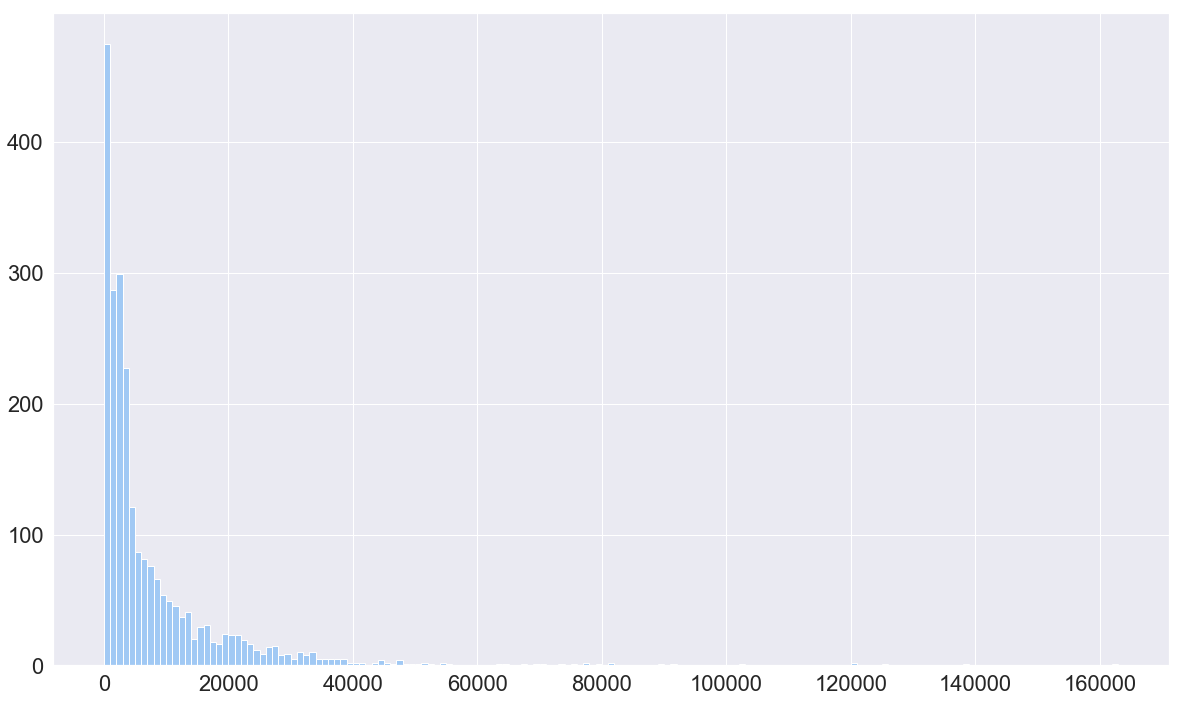

In [319]:
bins = np.arange(tweets_df['favorite_count'].min(), tweets_df['favorite_count'].max()+1000, 1000)
tweets_df['favorite_count'].hist(bins=bins);

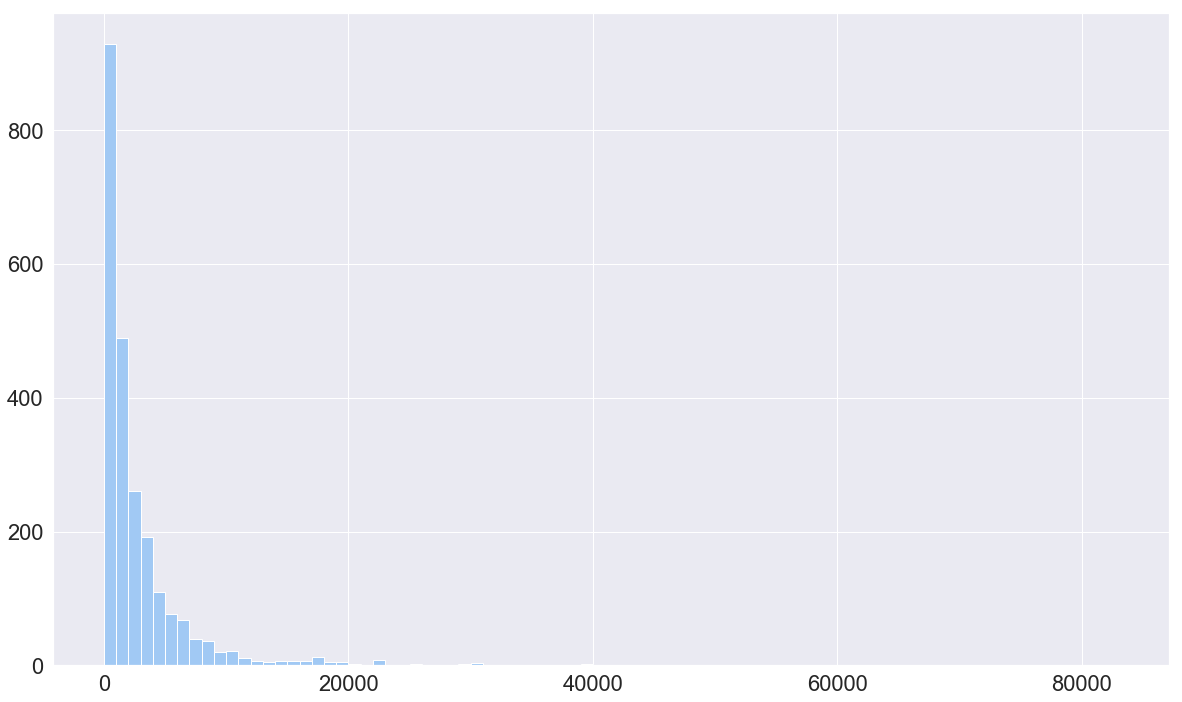

In [325]:
bins = np.arange(tweets_df['retweet_count'].min(), tweets_df['retweet_count'].max()+1000, 1000)
tweets_df['retweet_count'].hist(bins=bins);

In [332]:
# rows that are newer than 01st August 2017
tweets_df[pd.to_datetime(tweets_df['created_at']) > '2017-08-01'].shape[0]

2

**Result:**

Quality issue:

- Column `created_at` is not from type datetime.
- There are 2 rows that are newer than 1st August 2017.

## 3. Tidying + Cleaning

### Cleaning 
First dataframe:
1. Remove tweets with missing images (`expanded_urls`).
2. Remove retweets, tweets with retweet and user id (`retweeted_status_id`, `in_reply_to_user_id` and `in_reply_to_status_id` not null).
3. Convert column `timestamp` to data type datetime.
4. Remove dog names that starts with an lower case letter (set to np.NaN).
5. Remove dog names 'None' (set to np.NaN).
6. Remove rows that are newer than 1st August 2017.
7. Remove tweet with tweet_id: 810984652412424192, because numbers 24/7 is not meant as rating.
8. Overwrite ratings were the wrong `rating_numerator` and `rating_denumerator` were extracted. By using regex. If two divisor numbers are in the text, use the one with the 10 as denumerator.

Second dataframe:
/

Third dataframe:
9. Convert column `created_at` to type datetime.
10. There are 2 rows that are newer than 1st August 2017.


### Tidying
First dataframe:
1. Melt columns `doggo`, `floofer`, `pupper`, `puppo` to a new column `dog_stage`.

Second dataframe:
2. Bring information of all 3 predictions into only one with the best dog prediction (`p_dog` == True, `p` and `p_conf`).
    - If none of the pX_dog values are True, remove row (quality issue).

Third dataframe:
/

All dataframes:
3. Inner join on tweet_id (keep only tweets where data is available in all 3 dfs). Remove needless columns.
4. New feature: rating: numinator / denominator

### 3.1 Cleaning

The cleaning step is chosen first, to see more dirty data in single dataframes before joining all three dataframes. Usually Tidying would be the first step.

In [1566]:
# copy every dataframe
twitter_archive_df_cleaned = twitter_archive_df.copy()
prediction_df_cleaned = prediction_df.copy()
tweets_df_cleaned = tweets_df.copy()

<span style="color:blue">Define:</span>

1. Remove tweets with missing images (expanded_urls). Because they are no dog ratings.

<span style="color:purple">Code:</span>

In [1567]:
# tweets without image url are no original rating
#print(twitter_archive_df[twitter_archive_df['expanded_urls'].isnull()]) # for exploration
rows_before = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned.dropna(axis=0, subset=['expanded_urls'])

<span style="color:LightSeaGreen">Test:</span>

In [1568]:
print("Dropped ", rows_before-twitter_archive_df_cleaned.shape[0], " due to non-original rating tweets.")

Dropped  59  due to non-original rating tweets.


<span style="color:blue">Define:</span>

2. Remove retweets, tweets with retweet and user id (`retweeted_status_id`, `in_reply_to_user_id` and `in_reply_to_status_id` not null). Because they are retweet-tweets and no original rating tweets.

<span style="color:purple">Code:</span>

In [1569]:
# remove tweets with retweeted_status_id
#twitter_archive_df[~twitter_archive_df['retweeted_status_id'].isnull()] # for exploration
rows_before_0 = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned[twitter_archive_df_cleaned['retweeted_status_id'].isnull()]

<span style="color:LightSeaGreen">Test:</span>

In [1570]:
print("Dropped ", rows_before_0-twitter_archive_df_cleaned.shape[0], " due to re-tweets.")

Dropped  180  due to re-tweets.


<span style="color:purple">Code:</span>

In [1571]:
rows_before_1 = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned[twitter_archive_df_cleaned['in_reply_to_status_id'].isnull()]

<span style="color:LightSeaGreen">Test:</span>

In [1572]:
print("Dropped ", rows_before_1-twitter_archive_df_cleaned.shape[0], " due to re-tweets.")

Dropped  23  due to re-tweets.


<span style="color:purple">Code:</span>

In [1573]:
rows_before_2 = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned[twitter_archive_df_cleaned['in_reply_to_user_id'].isnull()]

<span style="color:LightSeaGreen">Test:</span>

In [1574]:
print("Dropped ", rows_before_2-twitter_archive_df_cleaned.shape[0], " due to re-tweets.")

Dropped  0  due to re-tweets.


<span style="color:blue">Define:</span>

*3*. Convert column `timestamp` to data type datetime.

*9*. Convert column `created_at` to data type datetime.

<span style="color:purple">Code:</span>

In [1575]:
# convert date columns to datetime
twitter_archive_df_cleaned['timestamp'] = pd.to_datetime(twitter_archive_df_cleaned['timestamp'])
tweets_df_cleaned['created_at'] = pd.to_datetime(tweets_df_cleaned['created_at'])

<span style="color:LightSeaGreen">Test:</span>

In [1576]:
print(type(twitter_archive_df_cleaned['timestamp'][0]), type(tweets_df_cleaned['created_at'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>


<span style="color:blue">Define:</span>

4. Remove dog names that starts with an lower case letter (set to np.NaN).
5. Remove dog names 'None' (set to np.NaN).

<span style="color:purple">Code:</span>

In [1577]:
twitter_archive_df_cleaned[twitter_archive_df_cleaned['name'].str.islower()]['name'].unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'my',
       'his', 'an', 'actually', 'just', 'getting', 'mad', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [1578]:
# rating tweets without dog name
#twitter_archive_df[twitter_archive_df['name'] == "None"].shape[0] # to explore
twitter_archive_df_cleaned.loc[twitter_archive_df_cleaned['name'].str.islower(),'name'] = np.NaN
twitter_archive_df_cleaned.loc[twitter_archive_df_cleaned['name'] == "None",'name'] = np.NaN

<span style="color:LightSeaGreen">Test:</span>

In [1579]:
print('Missings in column name before: ', twitter_archive_df['name'].isnull().sum())
print('Missings in column name after: ', twitter_archive_df_cleaned['name'].isnull().sum())

Missings in column name before:  0
Missings in column name after:  704


<span style="color:blue">Define:</span>

*6*. Remove rows that are newer than 1st August 2017. (first dataframe)

*10*. There are 2 rows that are newer than 1st August 2017. (third dataframe)

<span style="color:purple">Code:</span>

In [1580]:
# drop all newer than August 1st 2017
#tweets_df_cleaned[tweets_df_cleaned.created_at > '2017-08-01'] # to explore
rows_before_1 = tweets_df_cleaned.shape[0]
tweets_df_cleaned = tweets_df_cleaned[tweets_df_cleaned.created_at < '2017-08-01']
rows_before_2 = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned[twitter_archive_df_cleaned.timestamp < '2017-08-01']

<span style="color:LightSeaGreen">Test:</span>

In [1581]:
print("Dropped ", rows_before_1-tweets_df_cleaned.shape[0], " due to date limit")
print("Dropped ", rows_before_2-twitter_archive_df_cleaned.shape[0], " due to date limit")

Dropped  2  due to date limit
Dropped  2  due to date limit


<span style="color:blue">Define:</span>

7. Remove tweet with tweet_id: 810984652412424192, because numbers 24/7 is not meant as rating.

<span style="color:purple">Code:</span>



In [1582]:
twitter_archive_df_cleaned[twitter_archive_df_cleaned['tweet_id'] == 810984652412424192]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
516  810984652412424192                    NaN                  NaN   

                    timestamp  \
516 2016-12-19 23:06:23+00:00   

                                                source  \
516  <a href="http://twitter.com/download/iphone" r...   

                                                  text  retweeted_status_id  \
516  Meet Sam. She smiles 24/7 &amp; secretly aspir...                  NaN   

     retweeted_status_user_id retweeted_status_timestamp  \
516                       NaN                        NaN   

                                         expanded_urls  rating_numerator  \
516  https://www.gofundme.com/sams-smile,https://tw...                24   

     rating_denominator name doggo floofer pupper puppo  
516                   7  Sam  None    None   None  None

In [1583]:
index_of_invalid_rating = twitter_archive_df_cleaned[twitter_archive_df_cleaned['tweet_id'] == 810984652412424192].index
twitter_archive_df_cleaned.drop([index_of_invalid_rating[0]], inplace=True)

<span style="color:LightSeaGreen">Test:</span>

In [1584]:
twitter_archive_df_cleaned[twitter_archive_df_cleaned['tweet_id'] == 810984652412424192]

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []

In [1585]:
twitter_archive_df_cleaned.shape

(2091, 17)

<span style="color:blue">Define:</span>

8. Overwrite ratings were the wrong `rating_numerator` and `rating_denumerator` were extracted. By using regex. If two divisor numbers are in the text, use the one with the 10 as denumerator.

<span style="color:purple">Code:</span>



In [1586]:
twitter_archive_df_cleaned.head(1)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
2  891815181378084864                    NaN                  NaN   

                  timestamp  \
2 2017-07-31 00:18:03+00:00   

                                              source  \
2  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
2                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
2  https://twitter.com/dog_rates/status/891815181...                12   

   rating_denominator    name doggo floofer pupper puppo  
2                  10  Archie  None    None   None  None

In [1587]:
list(twitter_archive_df_cleaned)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [1588]:
#twitter_archive_df_cleaned.reset_index()
# helper column to tell if there are more than one '/' in the text
for i, row in twitter_archive_df_cleaned.iterrows():
    if type(row['text']) == str:
        twitter_archive_df_cleaned.loc[i, 'helper_slash_amount'] = twitter_archive_df_cleaned['text'][i].count('/')

In [1589]:
# different amount of slashes 
twitter_archive_df_cleaned['helper_slash_amount'].value_counts()

4.0    2035
5.0      27
7.0      27
6.0       2
Name: helper_slash_amount, dtype: int64

In [1590]:
print(twitter_archive_df_cleaned['helper_slash_amount'][100])
twitter_archive_df_cleaned['text'][100]

4.0


'Here are my favorite #dogsatpollingstations \nMost voted for a more consistent walking schedule and to increase daily pats tenfold. All 13/10 https://t.co/17FVMl4VZ5'

The url has 3 slashes too.

In [1591]:
twitter_archive_df_cleaned['helper_slash_amount'] = twitter_archive_df_cleaned['helper_slash_amount'] - 3

In [1592]:
# different amount of slashes 
twitter_archive_df_cleaned['helper_slash_amount'].value_counts()

1.0    2035
2.0      27
4.0      27
3.0       2
Name: helper_slash_amount, dtype: int64

For all invalid ratings (where denumerator is not 10 and there is another /10 in the text) replace with new extracted rating:

In [1593]:
twitter_archive_df_cleaned.shape

(2091, 18)

In [1594]:
twitter_archive_df_cleaned['rating_numerator'].value_counts()

12      485
10      434
11      413
13      285
9       153
8        98
7        52
14       38
5        34
6        32
3        19
4        16
2         9
1         5
26        1
44        1
165       1
60        1
50        1
144       1
80        1
84        1
88        1
121       1
204       1
420       1
1776      1
27        1
45        1
75        1
99        1
0         1
Name: rating_numerator, dtype: int64

In [1595]:
twitter_archive_df_cleaned['rating_denominator'].value_counts()

10     2075
50        3
11        2
80        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

In [1596]:
twitter_archive_df_cleaned[twitter_archive_df_cleaned['rating_numerator'].isnull()]

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo, helper_slash_amount]
Index: []

In [1597]:
where_denuminator_not_ten = twitter_archive_df_cleaned['rating_denominator'] != 10
where_more_than_one_slash = twitter_archive_df_cleaned['helper_slash_amount'] > 1
# s.str.extract(r'([0-9])*[/]10')

#twitter_archive_df_cleaned.loc[where_denuminator_not_ten & where_more_than_one_slash, 'rating_numerator'] =  twitter_archive_df_cleaned.loc[where_denuminator_not_ten & where_more_than_one_slash,'text'].str.extract(r'([0-9]*)[/]10').astype(np.float64)
twitter_archive_df_cleaned.loc[where_denuminator_not_ten & where_more_than_one_slash, 'rating_numerator'] = twitter_archive_df_cleaned.loc[where_denuminator_not_ten & where_more_than_one_slash,'text'].str.extract(r'([0-9]*)[/]10')#.astype('int64')
twitter_archive_df_cleaned.loc[where_denuminator_not_ten & where_more_than_one_slash, 'rating_denominator'] = 10

In [1598]:

test_text = twitter_archive_df_cleaned.loc[1165,'text']#.str.extract(r'([0-9]*)[/]10')
pd.Series(test_text).str.extract(r'([0-9]*)[/]10')

0
0  13

In [1599]:
twitter_archive_df_cleaned[twitter_archive_df_cleaned['rating_numerator'].isnull()]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1068  740373189193256964                    NaN                  NaN   
1165  722974582966214656                    NaN                  NaN   
1202  716439118184652801                    NaN                  NaN   
1662  682962037429899265                    NaN                  NaN   
2335  666287406224695296                    NaN                  NaN   

                     timestamp  \
1068 2016-06-08 02:41:38+00:00   
1165 2016-04-21 02:25:47+00:00   
1202 2016-04-03 01:36:11+00:00   
1662 2016-01-01 16:30:13+00:00   
2335 2015-11-16 16:11:11+00:00   

                                                 source  \
1068  <a href="http://twitter.com/download/iphone" r...   
1165  <a href="http://twitter.com/download/iphone" r...   
1202  <a href="http://twitter.com/download/iphone" r...   
1662  <a href="http://twitter.com/download/iphone" r...   
2335  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
1068  After so many requests, this is Bretagne. She ...                  NaN   
1165  Happy 4/20 from the squad! 13/10 for all https...                  NaN   
1202  This is Bluebert. He just saw that both #Final...                  NaN   
1662  This is Darrel. He just robbed a 7/11 and is i...                  NaN   
2335  This is an Albanian 3 1/2 legged  Episcopalian...                  NaN   

      retweeted_status_user_id retweeted_status_timestamp  \
1068                       NaN                        NaN   
1165                       NaN                        NaN   
1202                       NaN                        NaN   
1662                       NaN                        NaN   
2335                       NaN                        NaN   

                                          expanded_urls  rating_numerator  \
1068  https://twitter.com/dog_rates/status/740373189...               NaN   
1165  https://twitter.com/dog_rates/status/722974582...               NaN   
1202  https://twitter.com/dog_rates/status/716439118...               NaN   
1662  https://twitter.com/dog_rates/status/682962037...               NaN   
2335  https://twitter.com/dog_rates/status/666287406...               NaN   

      rating_denominator      name doggo floofer pupper puppo  \
1068                  10       NaN  None    None   None  None   
1165                  10       NaN  None    None   None  None   
1202                  10  Bluebert  None    None   None  None   
1662                  10    Darrel  None    None   None  None   
2335                  10       NaN  None    None   None  None   

      helper_slash_amount  
1068                  2.0  
1165                  2.0  
1202                  2.0  
1662                  2.0  
2335                  2.0

In [1600]:
# fix the null valies from previous function (do not know why it didn't worked for those in previous function)
for i, row in twitter_archive_df_cleaned[twitter_archive_df_cleaned['rating_numerator'].isnull()].iterrows():    
    test_text = twitter_archive_df_cleaned.loc[i,'text']#.str.extract(r'([0-9]*)[/]10')
    new_rating = pd.Series(test_text).str.extract(r'([0-9]*)[/]10')
    twitter_archive_df_cleaned.loc[i, 'rating_numerator'] = new_rating.astype('int64')

For 5 rows it doesn't worked to write the new read rating numerators. For now, they are deleted.

In [1601]:
# delete those rows where rating_numerator 
twitter_archive_df_cleaned.dropna(axis=0, subset=['rating_numerator'], inplace=True)

In [1602]:
twitter_archive_df_cleaned['rating_numerator'] = twitter_archive_df_cleaned['rating_numerator'].astype('int64')

In [1603]:
twitter_archive_df_cleaned.drop(columns=['helper_slash_amount'], inplace=True)

<span style="color:LightSeaGreen">Test:</span>

In [1604]:
twitter_archive_df_cleaned[twitter_archive_df_cleaned['rating_numerator'].isnull()]

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []

In [1605]:
twitter_archive_df_cleaned['rating_denominator'].value_counts()

10     2075
80        2
50        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
Name: rating_denominator, dtype: int64

In [1606]:
twitter_archive_df_cleaned['rating_numerator'].value_counts()

12      485
10      434
11      413
13      285
9       152
8        98
7        51
14       38
5        34
6        32
3        19
4        15
2         9
1         4
26        1
44        1
165       1
80        1
60        1
204       1
84        1
88        1
144       1
121       1
420       1
1776      1
27        1
45        1
75        1
99        1
0         1
Name: rating_numerator, dtype: int64

### 3.2 Tidying

In [1607]:
print("rows of twitter_archive_df_cleaned: ", twitter_archive_df_cleaned.shape[0])
print("rows of prediction_df_cleaned: ", prediction_df_cleaned.shape[0])
print("rows of tweets_df_cleaned: ", tweets_df_cleaned.shape[0])

rows of twitter_archive_df_cleaned:  2086
rows of prediction_df_cleaned:  2075
rows of tweets_df_cleaned:  2335


In [1608]:
print("columns of twitter_archive_df_cleaned: ", twitter_archive_df_cleaned.shape[1])
print("columns of prediction_df_cleaned: ", prediction_df_cleaned.shape[1])
print("columns of tweets_df_cleaned: ", tweets_df_cleaned.shape[1])

columns of twitter_archive_df_cleaned:  17
columns of prediction_df_cleaned:  12
columns of tweets_df_cleaned:  5


<span style="color:blue">Define:</span>

1. Melt columns doggo, floofer, pupper, puppo to a new column dog_stage.

<span style="color:purple">Code:</span>

In [1609]:
# melt the multiple stage variables into one variable
melted_stage = pd.melt(twitter_archive_df_cleaned, id_vars=['tweet_id'], value_vars=['doggo', 'floofer', 'pupper', 'puppo'], var_name='old_variable', value_name='dog_stage')

In [1610]:
list(melted_stage)

['tweet_id', 'old_variable', 'dog_stage']

In [1611]:
# drop old variable name
melted_stage = melted_stage.drop(columns=['old_variable'])
print(melted_stage.shape)
melted_stage.head()

(8344, 2)


tweet_id dog_stage
0  891815181378084864      None
1  891689557279858688      None
2  891327558926688256      None
3  891087950875897856      None
4  890971913173991426      None

In [1612]:
# remove null values
melted_stage['dog_stage'].replace({'None': np.NaN}, inplace=True)
melted_stage = melted_stage.dropna()
#melted_stage.shape
melted_stage['dog_stage'].value_counts()

pupper     229
doggo       83
puppo       24
floofer     10
Name: dog_stage, dtype: int64

In [1613]:
melted_stage['tweet_id'].duplicated().sum()

11

**Note**: There are some duplicates, because some dogs have several stages. They will kept as multiple rows.


In [1614]:
# join or merge stage values to dataframe
#twitter_archive_df_cleaned = twitter_archive_df_cleaned.join(melted_stage, on='tweet_id', how='left', lsuffix='', rsuffix='_right')
twitter_archive_df_cleaned = twitter_archive_df_cleaned.merge(melted_stage, left_on='tweet_id', right_on='tweet_id', how='left', suffixes=('', '_right'))
twitter_archive_df_cleaned.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

<span style="color:LightSeaGreen">Test:</span>

In [1615]:
twitter_archive_df_cleaned['dog_stage'].value_counts()

pupper     229
doggo       83
puppo       24
floofer     10
Name: dog_stage, dtype: int64

In [1616]:
list(twitter_archive_df_cleaned)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage']

<span style="color:blue">Define:</span>

2. Bring information of all 3 predictions into only one with the best dog prediction (p_dog == True, p and p_conf).
    - If none of the pX_dog values are True, remove row (quality issue).
    
--> To make tidying easier/faster: Only the first prediction was considered for tidying.

<span style="color:purple">Code:</span>
    


If the neural network can not predict that it is a dog from the image, then it will be removed.

In [1617]:
#prediction_df_cleaned[prediction_df.p1_dog == False] # for exploration
rows_before = prediction_df_cleaned.shape[0]
prediction_df_cleaned = prediction_df_cleaned[prediction_df.p1_dog == True]

<span style="color:LightSeaGreen">Test:</span>

In [1618]:
print("Dropped ", rows_before-prediction_df_cleaned.shape[0], " due to no-dog prediction.")

Dropped  543  due to no-dog prediction.


<span style="color:blue">Define:</span>

3. Inner join on tweet_id (keep only tweets where data is available in all 3 dfs). Remove needless columns.

<span style="color:purple">Code:</span>

In [1619]:
# join twitter_archive_df_cleaned and prediction_df_cleaned
joined_df = twitter_archive_df_cleaned.join(prediction_df_cleaned.set_index('tweet_id'), on='tweet_id', how='inner')

<span style="color:LightSeaGreen">Test:</span>

In [1620]:
print("Row and column before: ", twitter_archive_df_cleaned.shape)
print("Row and column after: ", joined_df.shape)

Row and column before:  (2097, 14)
Row and column after:  (1466, 25)


In [1621]:
list(joined_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

<span style="color:purple">Code:</span>

In [1622]:
# join also with tweets_df_cleaned
shape_before = joined_df.shape
joined_df = joined_df.join(tweets_df_cleaned.set_index('tweet_id'), on='tweet_id', how='inner', lsuffix='', rsuffix='_otweet')

<span style="color:LightSeaGreen">Test:</span>

In [1623]:
print("Row and column before: ", shape_before)
print("Row and column after: ", joined_df.shape)

Row and column before:  (1466, 25)
Row and column after:  (1462, 29)


In [1624]:
joined_df.head(2)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  891815181378084864                    NaN                  NaN   
2  891327558926688256                    NaN                  NaN   

                  timestamp  \
0 2017-07-31 00:18:03+00:00   
2 2017-07-29 16:00:24+00:00   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
2  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
2                       NaN                        NaN   

                                       expanded_urls  ...                p2  \
0  https://twitter.com/dog_rates/status/891815181...  ...          malamute   
2  https://twitter.com/dog_rates/status/891327558...  ...  English_springer   

    p2_conf p2_dog                           p3   p3_conf  p3_dog  \
0  0.078253   True                       kelpie  0.031379    True   
2  0.225770   True  German_short-haired_pointer  0.175219    True   

                                         text_otweet  favorite_count  \
0  This is Archie. He is a rare Norwegian Pouncin...           24348   
2  This is Franklin. He would like you to stop ca...           39127   

   retweet_count                created_at  
0           4009 2017-07-31 00:18:03+00:00  
2           9050 2017-07-29 16:00:24+00:00  

[2 rows x 29 columns]

In [1625]:
list(joined_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'text_otweet',
 'favorite_count',
 'retweet_count',
 'created_at']

Check if the duplicated column for timestamps have the same content:

In [1626]:
# check if timestamps are all the same after joining
joined_df[joined_df['timestamp'] != joined_df['created_at']].shape

(0, 29)

In [1627]:
#joined_df[joined_df['jpg_url'] == joined_df['expanded_urls']] # for exploration

<span style="color:blue">Define:</span>

4. New feature: rating: numinator / denominator

<span style="color:purple">Code:</span>
    


In [1628]:
joined_df['rating'] = joined_df['rating_numerator'].astype(np.float64) / joined_df['rating_denominator'].astype(np.float64)

<span style="color:LightSeaGreen">Test:</span>

In [1629]:
joined_df[['rating', 'rating_numerator', 'rating_denominator']].head()

rating  rating_numerator  rating_denominator
0     1.2                12                  10
2     1.2                12                  10
3     1.3                13                  10
4     1.3                13                  10
5     1.3                13                  10

In [1630]:
joined_df['rating'].unique()

array([1.2, 1.3, 1.4, 0.5, 1.1, 0.6, 1. , 7.5, 2.7, 0.3, 0.9, 0.8, 0.7,
       0.4, 2.6, 0.2])

### 3.1 Cleaning - Addition after tidying

<span style="color:blue">Define:</span>

Remove all columns that are duplicates or that are not needed for later analysis:

<span style="color:purple">Code:</span>


In [1631]:
# remove needless columns
joined_df.drop(columns=['created_at', 'in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'text_otweet', 'expanded_urls'], inplace=True)

<span style="color:LightSeaGreen">Test:</span>

In [1632]:
joined_df.head()

tweet_id                 timestamp  \
0  891815181378084864 2017-07-31 00:18:03+00:00   
2  891327558926688256 2017-07-29 16:00:24+00:00   
3  891087950875897856 2017-07-29 00:08:17+00:00   
4  890971913173991426 2017-07-28 16:27:12+00:00   
5  890729181411237888 2017-07-28 00:22:40+00:00   

                                                text  rating_numerator  \
0  This is Archie. He is a rare Norwegian Pouncin...                12   
2  This is Franklin. He would like you to stop ca...                12   
3  Here we have a majestic great white breaching ...                13   
4  Meet Jax. He enjoys ice cream so much he gets ...                13   
5  When you watch your owner call another dog a g...                13   

   rating_denominator      name dog_stage  \
0                  10    Archie       NaN   
2                  10  Franklin       NaN   
3                  10       NaN       NaN   
4                  10       Jax       NaN   
5                  10       NaN       NaN   

                                           jpg_url  img_num  \
0  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg        1   
2  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg        2   
3  https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg        1   
4  https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg        1   
5  https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg        2   

                         p1  ...  p1_dog                p2   p2_conf  p2_dog  \
0                 Chihuahua  ...    True          malamute  0.078253    True   
2                    basset  ...    True  English_springer  0.225770    True   
3  Chesapeake_Bay_retriever  ...    True     Irish_terrier  0.116317    True   
4               Appenzeller  ...    True     Border_collie  0.199287    True   
5                Pomeranian  ...    True        Eskimo_dog  0.178406    True   

                            p3   p3_conf  p3_dog  favorite_count  \
0                       kelpie  0.031379    True           24348   
2  German_short-haired_pointer  0.175219    True           39127   
3              Indian_elephant  0.076902   False           19681   
4                    ice_lolly  0.193548   False           11503   
5                     Pembroke  0.076507    True           63431   

   retweet_count  rating  
0           4009     1.2  
2           9050     1.2  
3           3005     1.3  
4           1985     1.3  
5          18212     1.3  

[5 rows x 21 columns]

In [1633]:
joined_df.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'favorite_count', 'retweet_count', 'rating'],
      dtype='object')

In [1634]:
joined_df.shape

(1462, 21)

### 3.3 Store cleaned and tidies data

In [1635]:
joined_df.to_csv('../data/twitter_archive_master.csv', index=False)

In [1636]:
conn = sqlite3.connect("../data/twitter_archive_master.db")
joined_df.to_sql("twitter_archive_master", conn, if_exists="replace", index=False)

In [1637]:
# test
df = pd.read_sql_query("select * from twitter_archive_master;", conn)
df.head()

tweet_id                  timestamp  \
0  891815181378084864  2017-07-31 00:18:03+00:00   
1  891327558926688256  2017-07-29 16:00:24+00:00   
2  891087950875897856  2017-07-29 00:08:17+00:00   
3  890971913173991426  2017-07-28 16:27:12+00:00   
4  890729181411237888  2017-07-28 00:22:40+00:00   

                                                text  rating_numerator  \
0  This is Archie. He is a rare Norwegian Pouncin...                12   
1  This is Franklin. He would like you to stop ca...                12   
2  Here we have a majestic great white breaching ...                13   
3  Meet Jax. He enjoys ice cream so much he gets ...                13   
4  When you watch your owner call another dog a g...                13   

   rating_denominator      name dog_stage  \
0                  10    Archie      None   
1                  10  Franklin      None   
2                  10      None      None   
3                  10       Jax      None   
4                  10      None      None   

                                           jpg_url  img_num  \
0  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg        1   
1  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg        2   
2  https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg        1   
3  https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg        1   
4  https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg        2   

                         p1  ...  p1_dog                p2   p2_conf  p2_dog  \
0                 Chihuahua  ...       1          malamute  0.078253       1   
1                    basset  ...       1  English_springer  0.225770       1   
2  Chesapeake_Bay_retriever  ...       1     Irish_terrier  0.116317       1   
3               Appenzeller  ...       1     Border_collie  0.199287       1   
4                Pomeranian  ...       1        Eskimo_dog  0.178406       1   

                            p3   p3_conf  p3_dog  favorite_count  \
0                       kelpie  0.031379       1           24348   
1  German_short-haired_pointer  0.175219       1           39127   
2              Indian_elephant  0.076902       0           19681   
3                    ice_lolly  0.193548       0           11503   
4                     Pembroke  0.076507       1           63431   

   retweet_count  rating  
0           4009     1.2  
1           9050     1.2  
2           3005     1.3  
3           1985     1.3  
4          18212     1.3  

[5 rows x 21 columns]

In [1638]:
df.shape

(1462, 21)

## 4. Analyze and Visualize


### Most rated value

the most rated values and the highest rated value:

In [1641]:
df['rating_numerator'].value_counts()

12     382
10     317
11     306
13     207
9      106
8       58
7       24
14      19
6       12
5       11
4        4
3        3
165      1
121      1
26       1
27       1
44       1
45       1
60       1
75       1
80       1
84       1
88       1
99       1
2        1
Name: rating_numerator, dtype: int64

### Best rated dogs

SPOTTED: There is a error in the rate extraction from text, because in the tweet the dog has a rate of 9.75 not 75. 

Also the rating 27 is meant as a 11.27 ratings. So they weren't extracted correctly. Now they must be cleaned as well.

In [1648]:
#df[df['rating_numerator'] == 27] # test
rows = df.shape[0]
df = df[df['rating_numerator'] != 27]
df = df[df['rating_numerator'] != 75]
df = df[df['rating_numerator'] != 26]

print("Dropped ", rows-df.shape[0], ' after removing wrong computed ratings.')

Dropped  1  after removing wrong computed ratings.


The maximum value that was given as rating:

In [1649]:
df['rating'].max()

1.4

The amount of tweets (dogs) that received the maximum rating:

In [1650]:
df_best_rated = df[df['rating'] == df['rating'].max()]
df_best_rated = df_best_rated.reset_index(drop=True)
df_best_rated.shape

(19, 21)

Those are the dogs that received the maxium rating 14/10:

Dog name:  Cassie
Dog breed:  Pembroke
prediction rate:  0.511319
rate:  14 / 10
text:  This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A


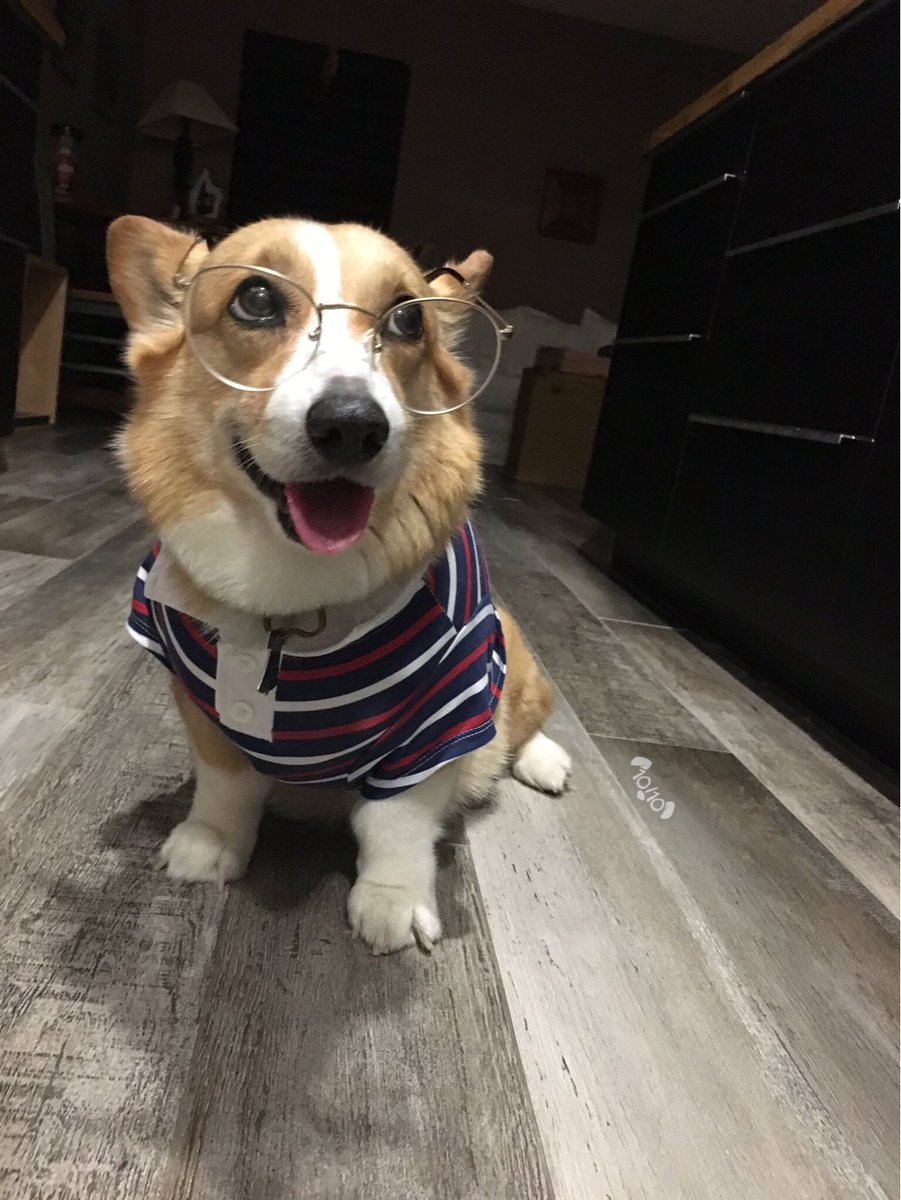

Dog name:  None
Dog breed:  Pembroke
prediction rate:  0.993225
rate:  14 / 10
text:  I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC


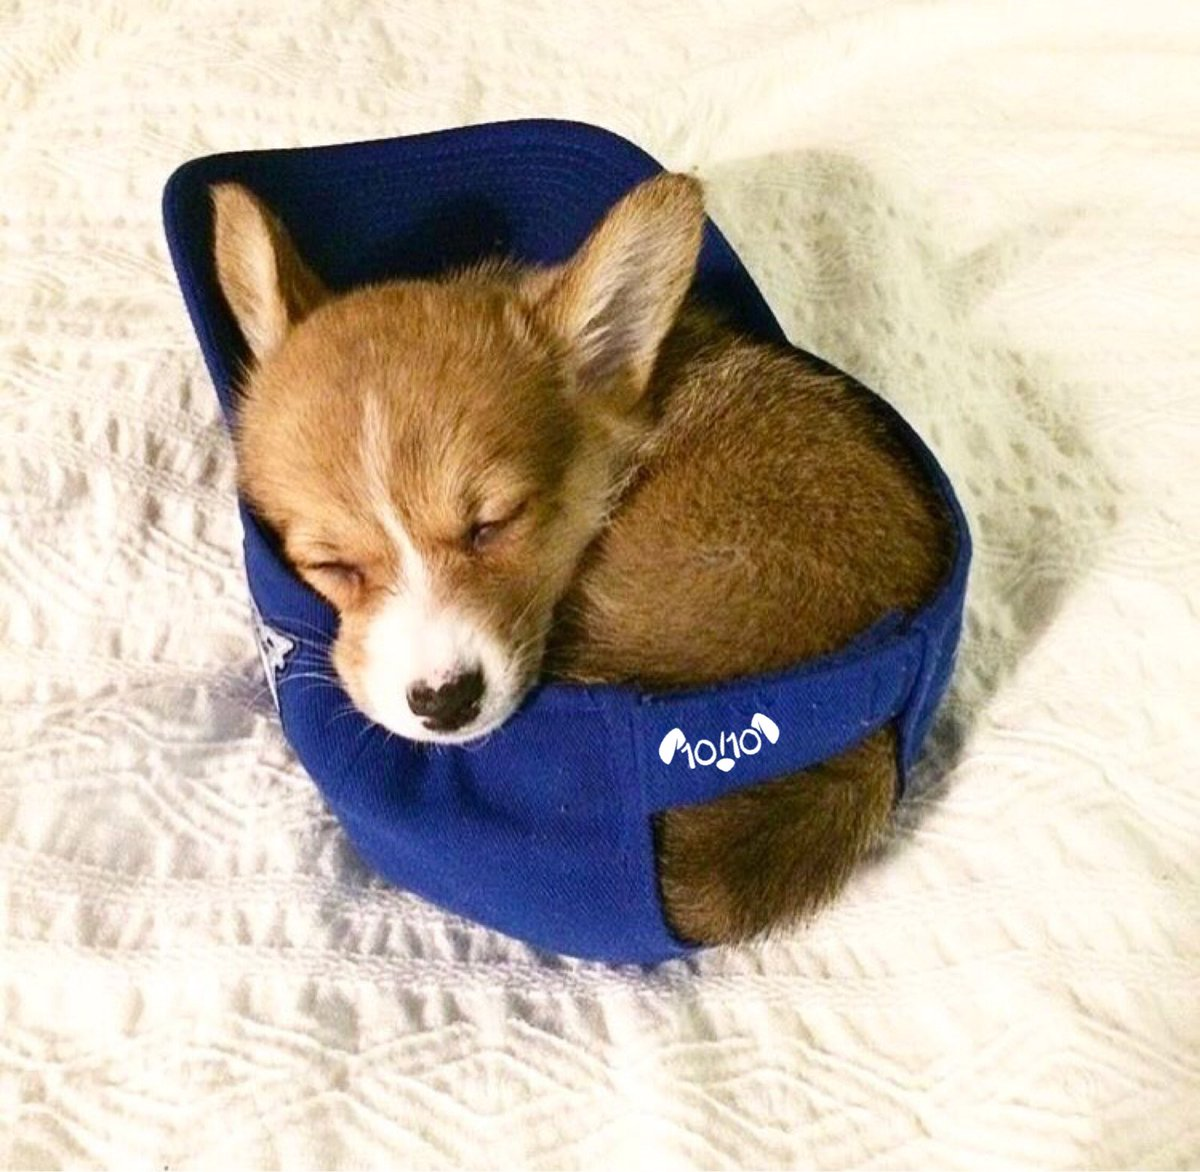

Dog name:  None
Dog breed:  Samoyed
prediction rate:  0.281463
rate:  14 / 10
text:  Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af 
(IG: puffie_the_chow) https://t.co/ghXBIIeQZF


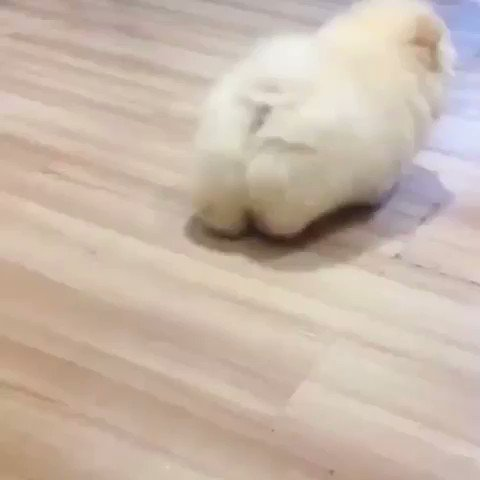

Dog name:  Emmy
Dog breed:  French_bulldog
prediction rate:  0.839097
rate:  14 / 10
text:  This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://t.co/cwtWnHMVpe


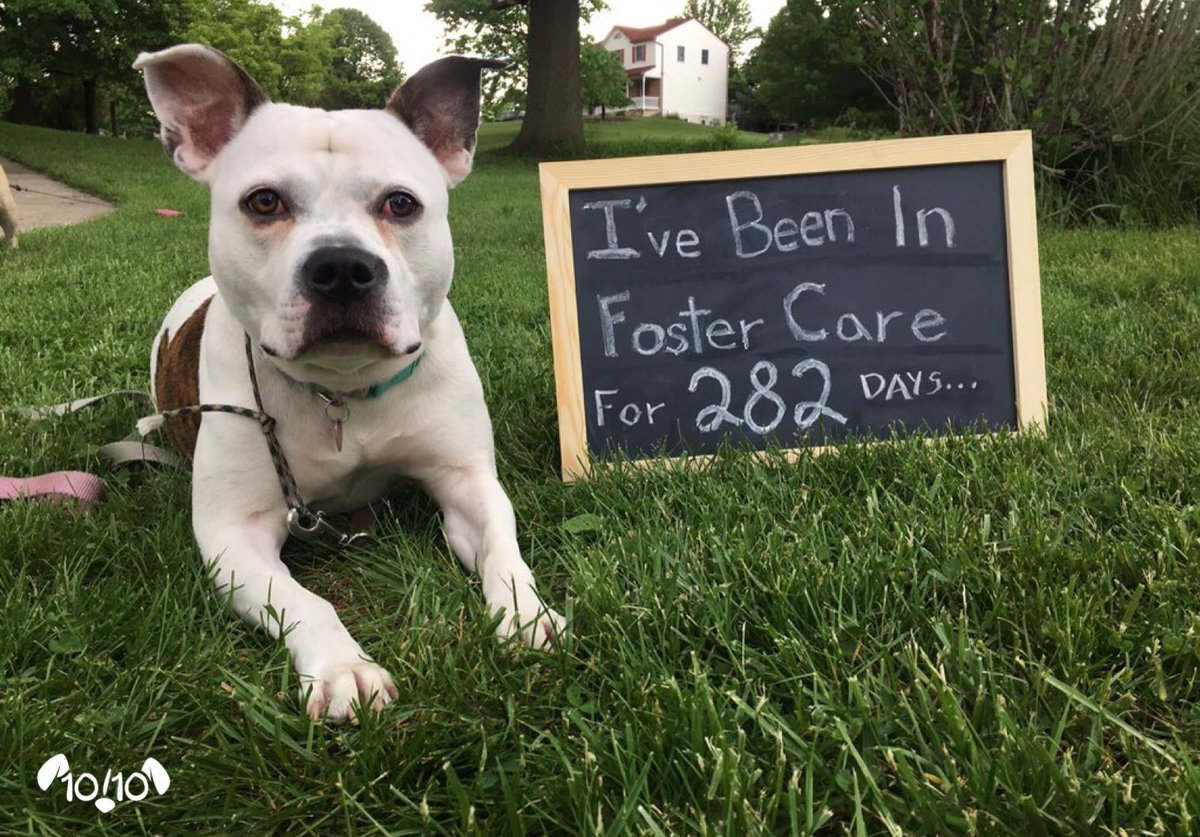

Dog name:  Cermet
Dog breed:  Chihuahua
prediction rate:  0.8765430000000001
rate:  14 / 10
text:  This is Cermet, Paesh, and Morple. They are absolute h*ckin superstars. Watered every day so they can grow. 14/10 for all https://t.co/GUefqUmZv8


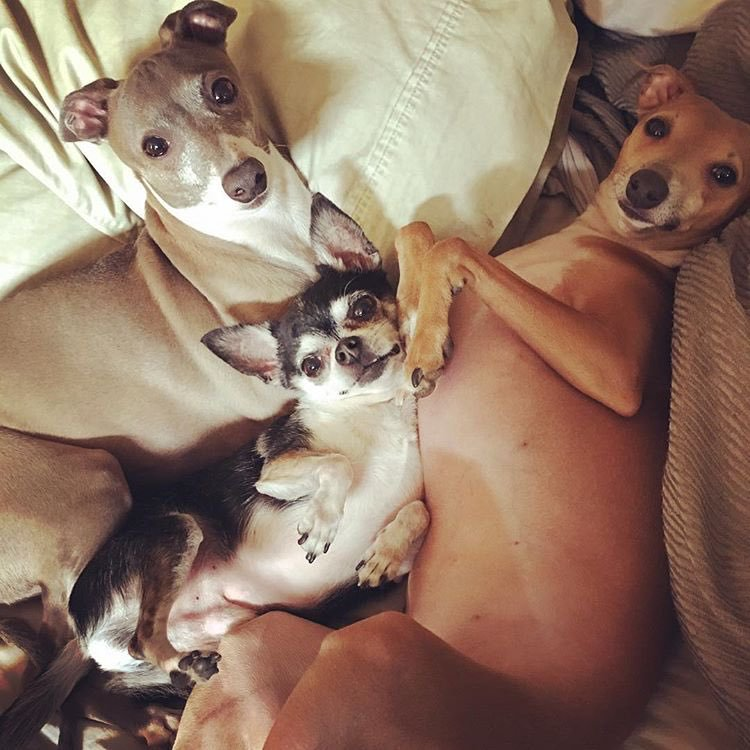

Dog name:  None
Dog breed:  black-and-tan_coonhound
prediction rate:  0.8548610000000001
rate:  14 / 10
text:  Sometimes you guys remind me just how impactful a pupper can be. Cooper will be remembered as a good boy by so many. 14/10 rest easy friend https://t.co/oBL7LEJEzR


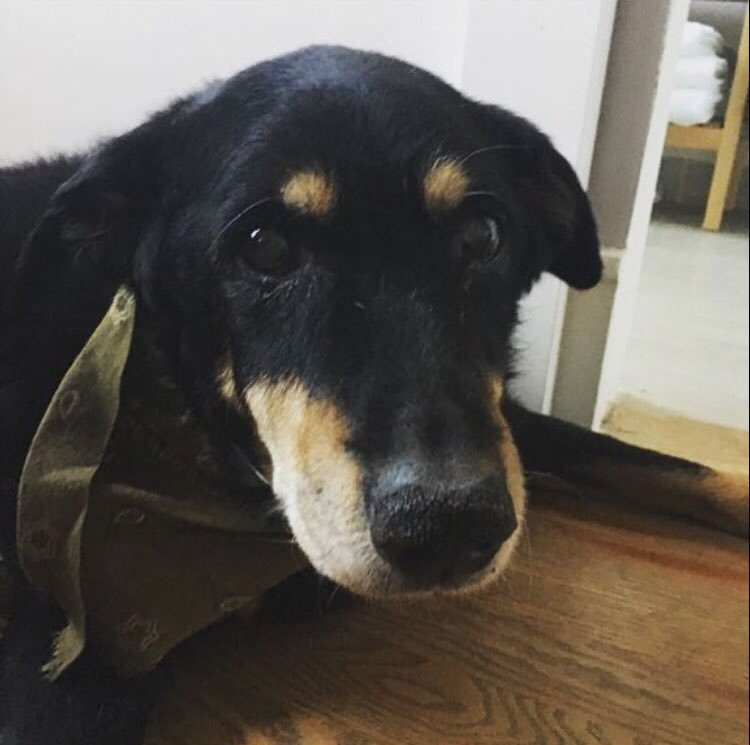

Dog name:  Smiley
Dog breed:  Pembroke
prediction rate:  0.134081
rate:  14 / 10
text:  Say hello to Smiley. He's a blind therapy doggo having a h*ckin blast high steppin around in the snow. 14/10 would follow anywhere https://t.co/SHAb1wHjMz


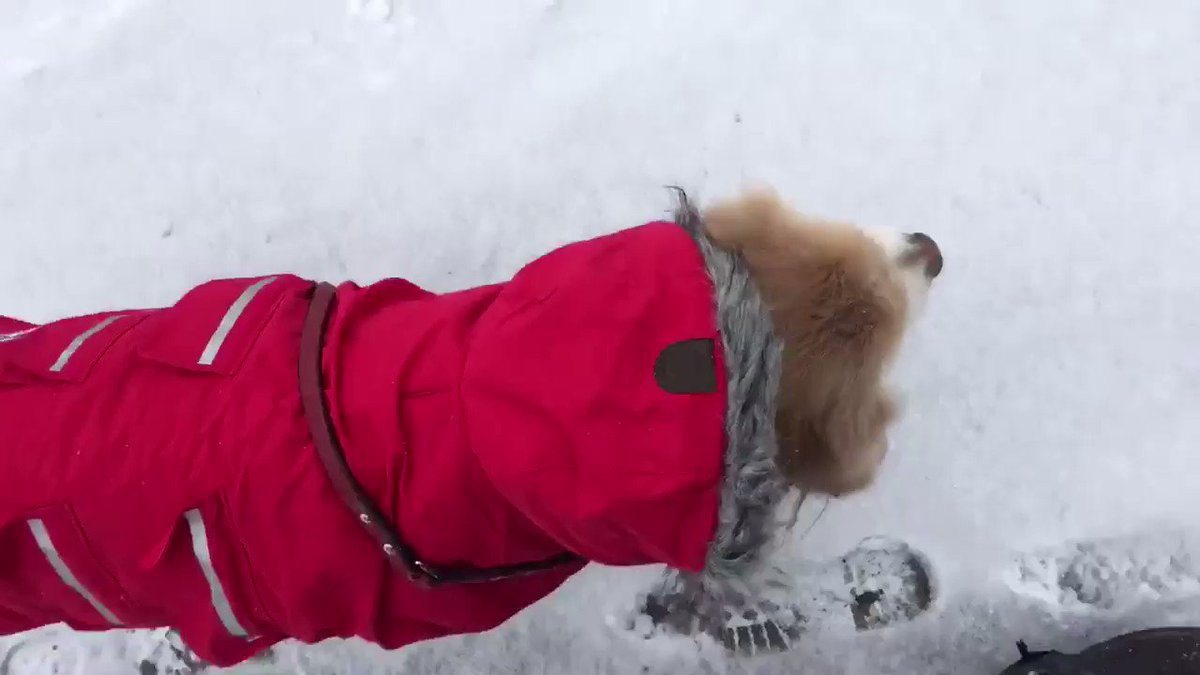

Dog name:  Kuyu
Dog breed:  bloodhound
prediction rate:  0.777562
rate:  14 / 10
text:  Meet Kuyu. He was trapped in a well for 10 days. Rescued yesterday using a device designed by a local robotics team. 14/10 for all involved https://t.co/l38R6IZNNg


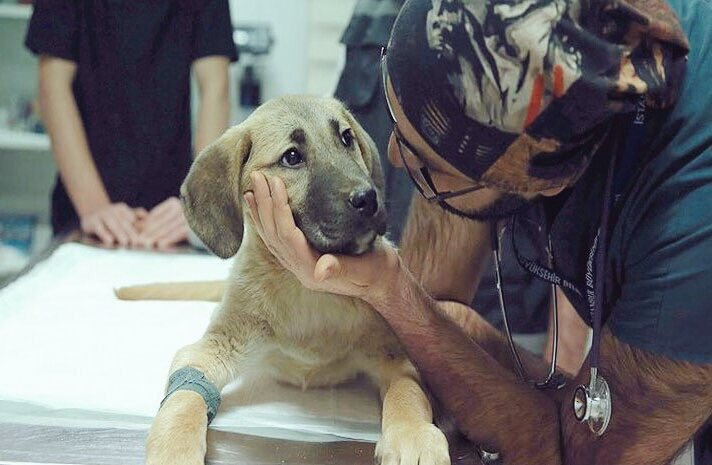

Dog name:  None
Dog breed:  golden_retriever
prediction rate:  0.649209
rate:  14 / 10
text:  Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK


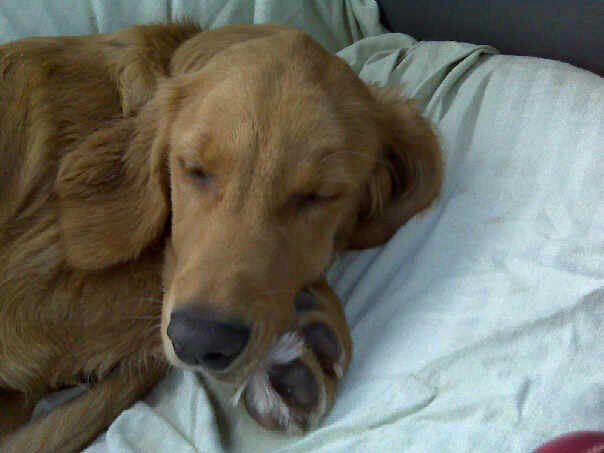

Dog name:  Doobert
Dog breed:  Bedlington_terrier
prediction rate:  0.392535
rate:  14 / 10
text:  Meet Doobert. He's a deaf doggo. Didn't stop him on the field tho. Absolute legend today. 14/10 would pat head approvingly https://t.co/iCk7zstRA9


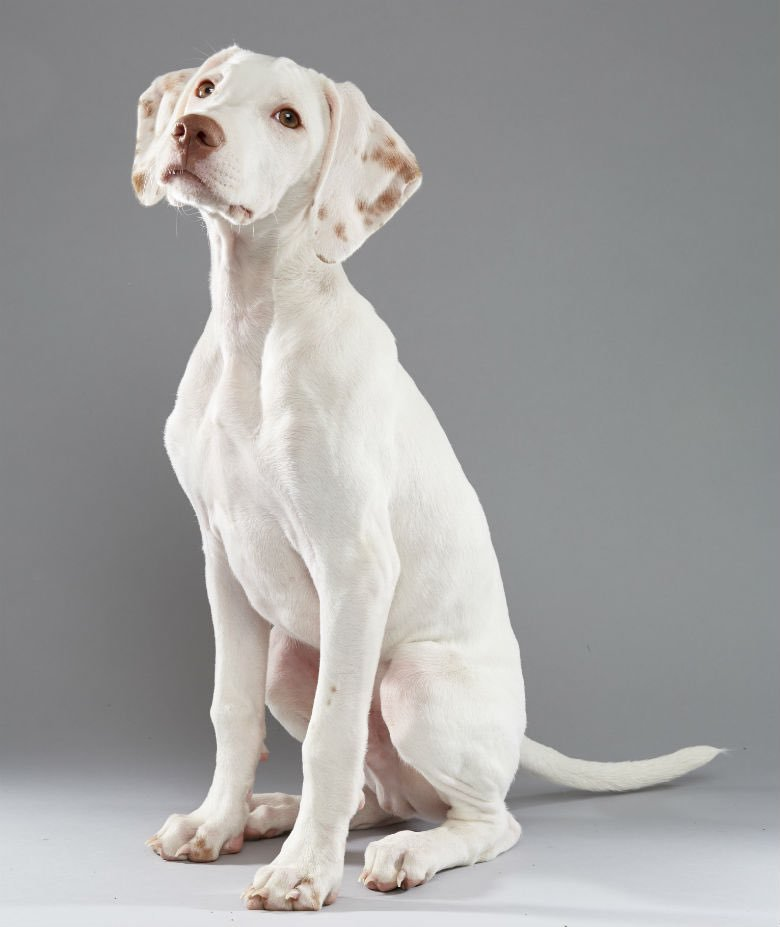

Dog name:  None
Dog breed:  Rottweiler
prediction rate:  0.681495
rate:  14 / 10
text:  Here's a very loving and accepting puppo. Appears to have read her Constitution well. 14/10 would pat head approvingly https://t.co/6ao80wIpV1


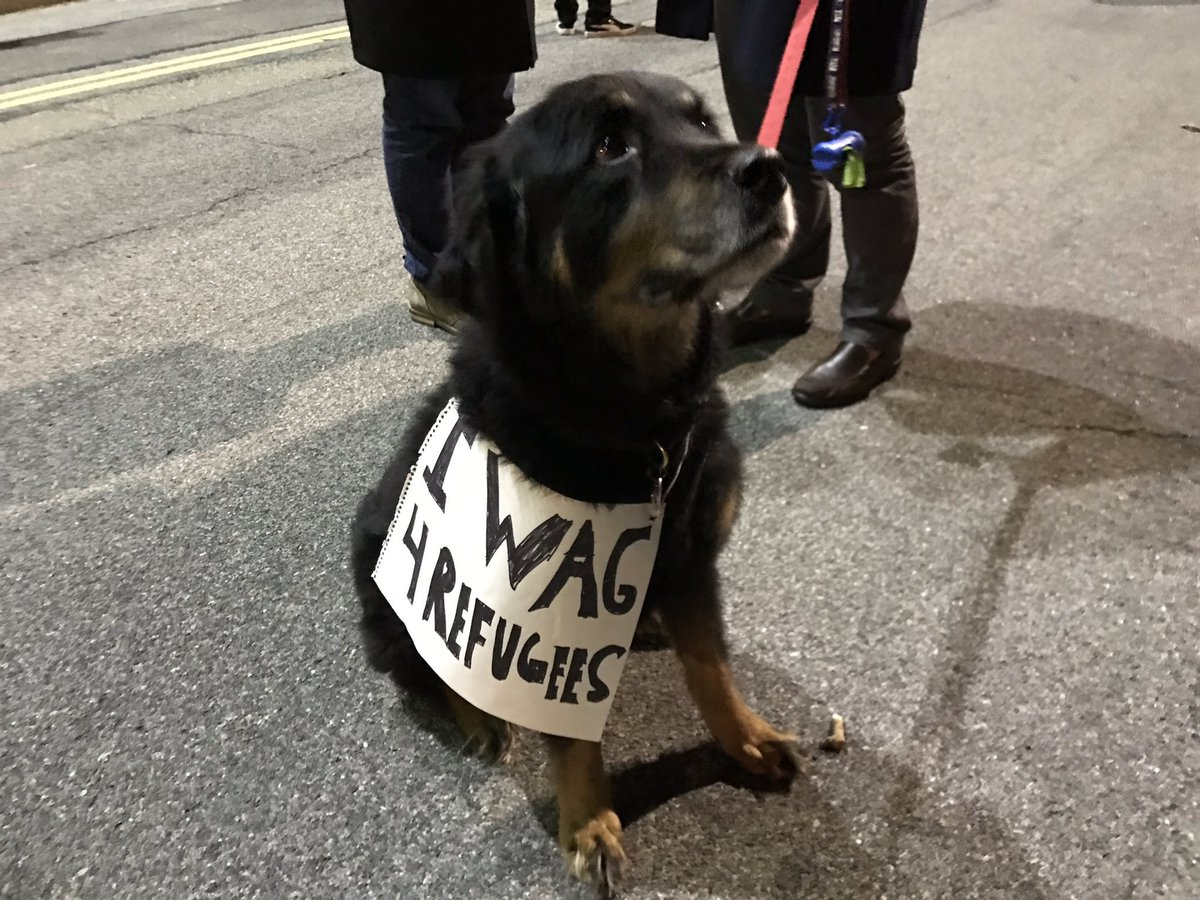

Dog name:  Gabe
Dog breed:  Pomeranian
prediction rate:  0.960199
rate:  14 / 10
text:  This is Gabe. He was the unequivocal embodiment of a dream meme, but also one h*ck of a pupper. You will be missed by so many. 14/10 RIP https://t.co/M3hZGadUuO


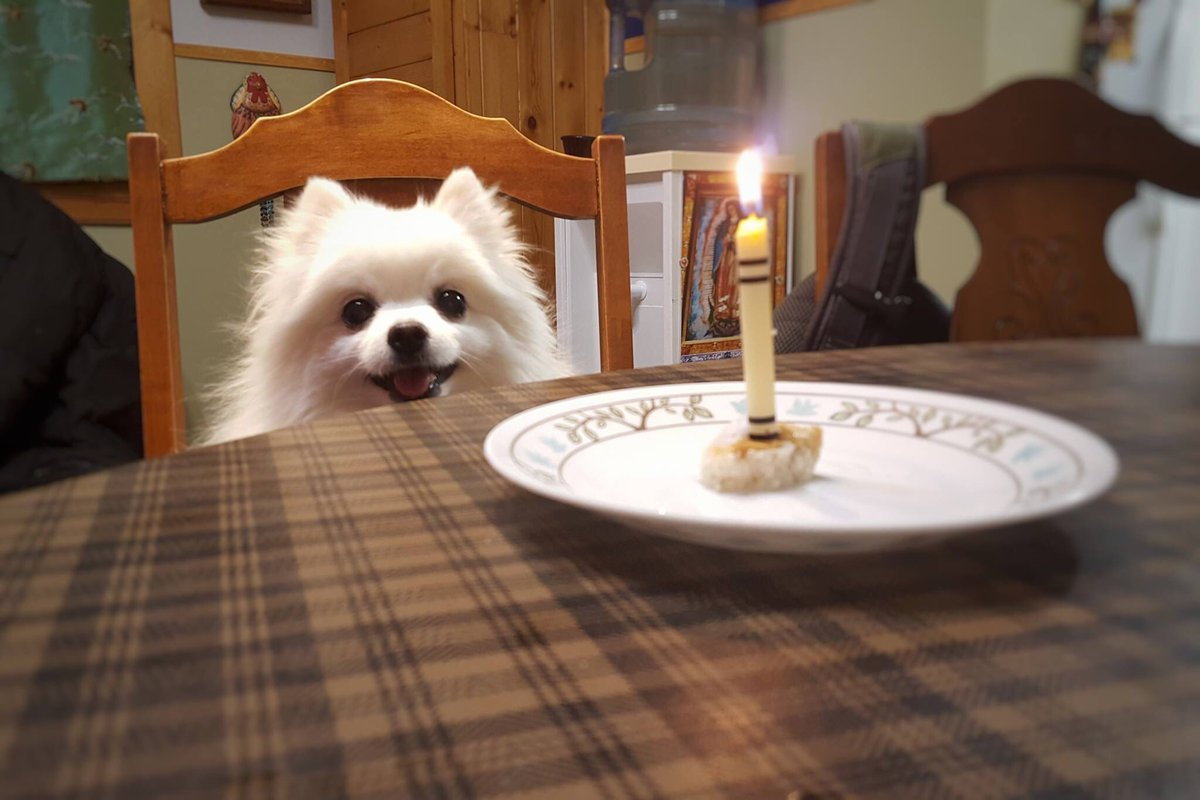

Dog name:  Sundance
Dog breed:  Irish_setter
prediction rate:  0.5054960000000001
rate:  14 / 10
text:  This is Sundance. He's a doggo drummer. Even sings a bit on the side. 14/10 entertained af (vid by @sweetsundance) https://t.co/Xn5AQtiqzG


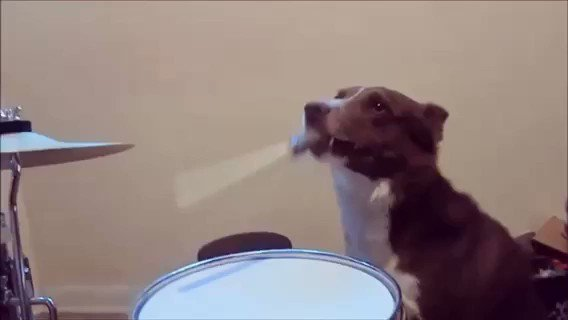

Dog name:  None
Dog breed:  Gordon_setter
prediction rate:  0.940724
rate:  14 / 10
text:  We are proud to support @LoveYourMelon on their mission to put a hat on every kid battling cancer. They are 14/10

https://t.co/XQlmPTLHPl https://t.co/ZNIkkHgtYE


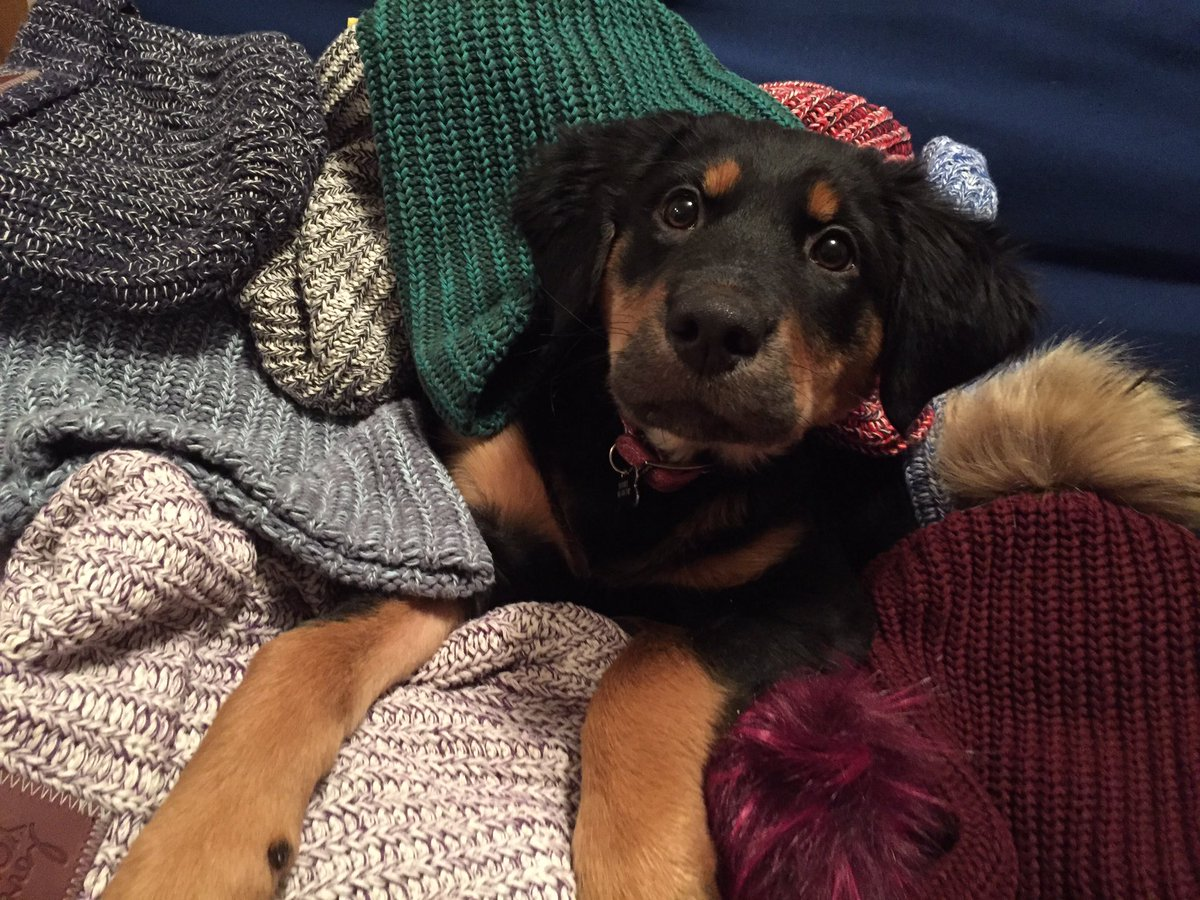

Dog name:  Bo
Dog breed:  standard_poodle
prediction rate:  0.351308
rate:  14 / 10
text:  This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1


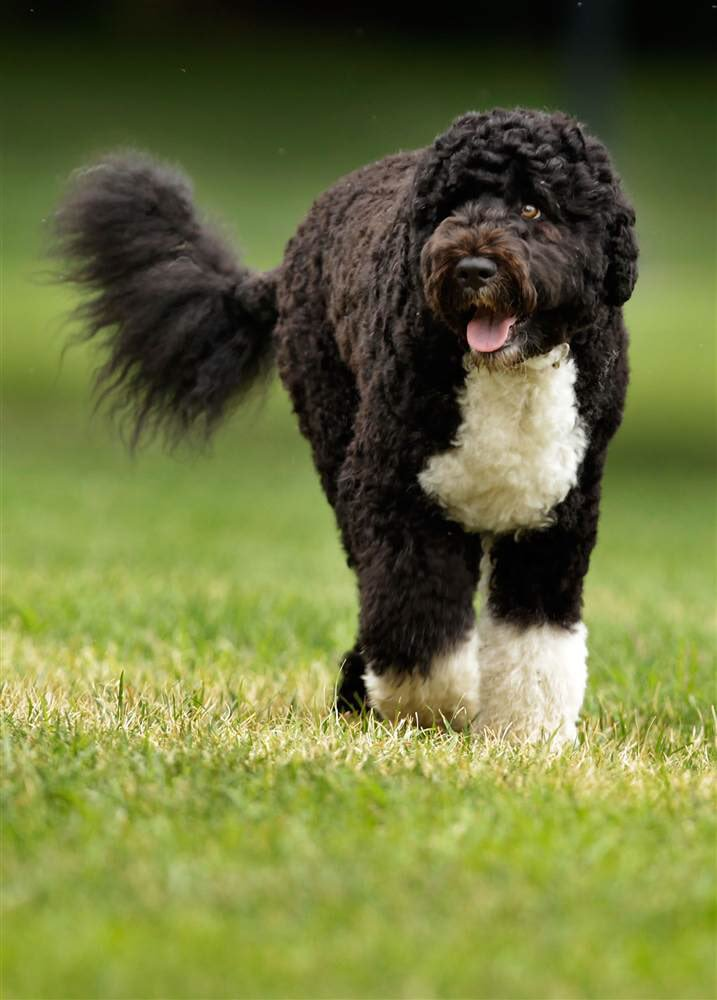

Dog name:  Gary
Dog breed:  French_bulldog
prediction rate:  0.709146
rate:  14 / 10
text:  Meet Gary, Carrie Fisher's dog. Idk what I can say about Gary that reflects the inspirational awesomeness that was Carrie Fisher. 14/10 RIP https://t.co/uBnQTNEeGg


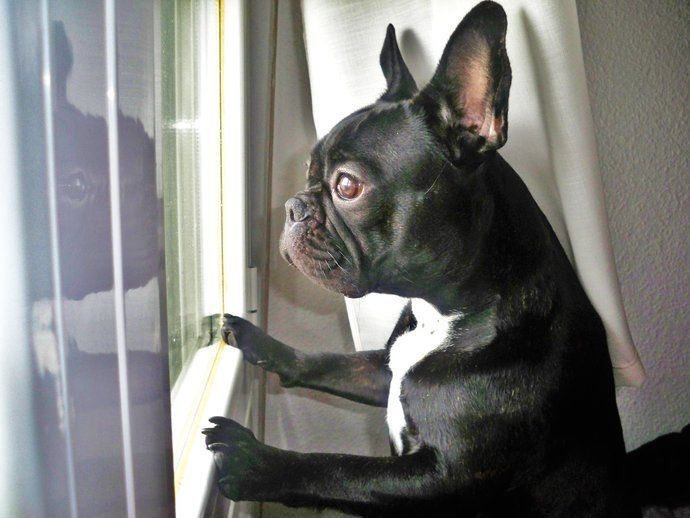

Dog name:  Ollie
Dog breed:  golden_retriever
prediction rate:  0.873233
rate:  14 / 10
text:  This is Ollie Vue. He was a 3 legged pupper on a mission to overcome everything. This is very hard to write. 14/10 we will miss you Ollie https://t.co/qTRY2qX9y4


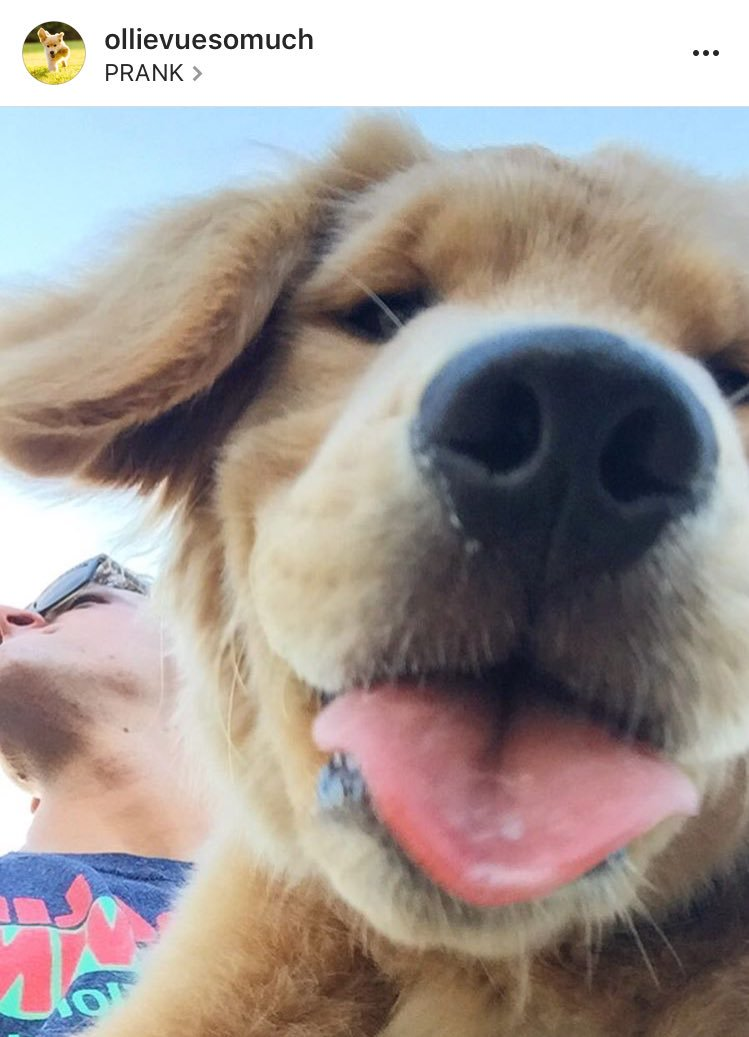

Dog name:  None
Dog breed:  Pembroke
prediction rate:  0.8483620000000001
rate:  14 / 10
text:  RIP Loki. Thank you for the good times. You will be missed by many. 14/10 https://t.co/gJKD9pst5A


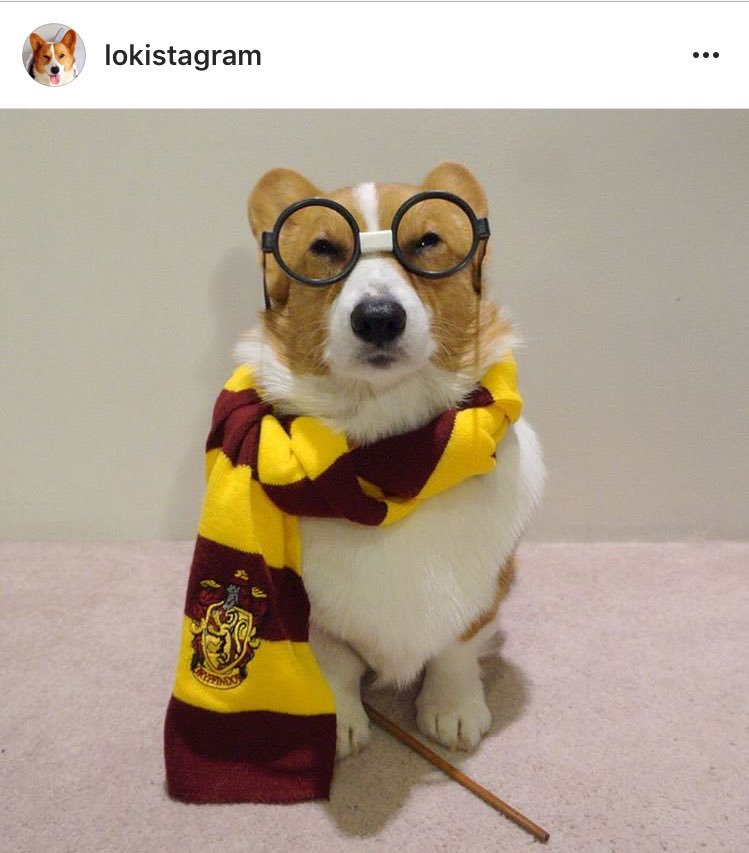

Dog name:  None
Dog breed:  Eskimo_dog
prediction rate:  0.5960449999999999
rate:  14 / 10
text:  I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC BY HIS OWNER THIS IS SO WILD. 14/10 ULTIMATE LEGEND STATUS https://t.co/7oQ1wpfxIH


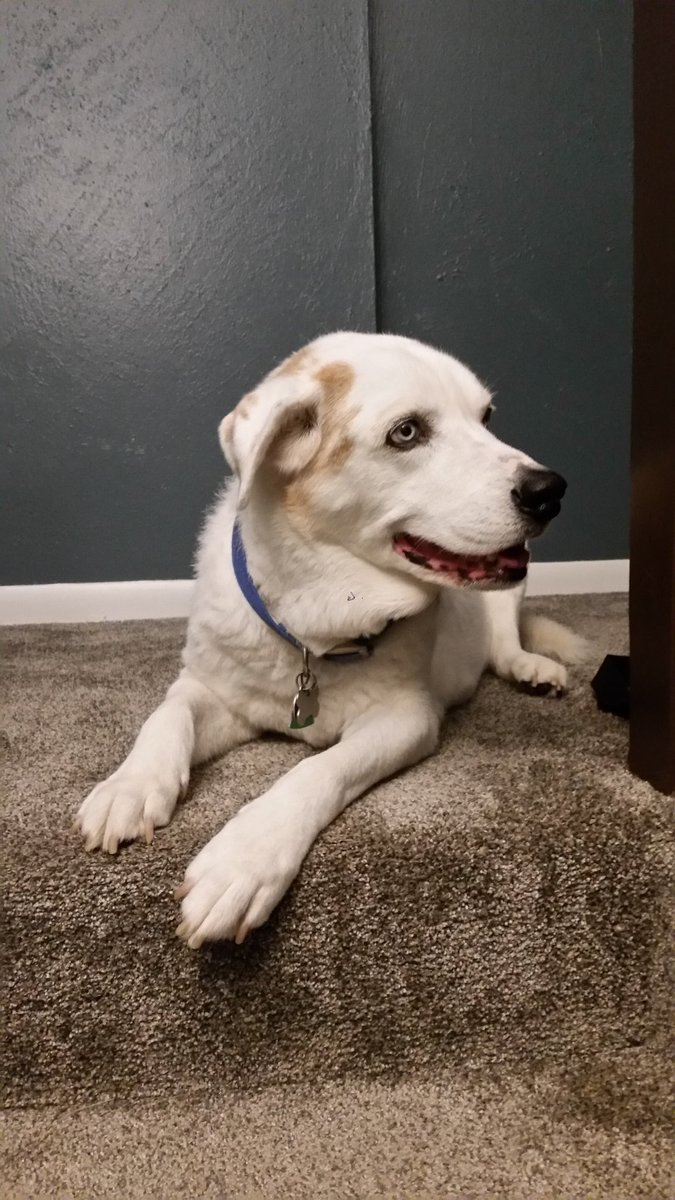

In [1651]:
for dog in range(df_best_rated.shape[0]):
    dog_url = df_best_rated['jpg_url'][dog]
    print('Dog name: ', df_best_rated['name'][dog])
    print('Dog breed: ', df_best_rated['p1'][dog])
    print('prediction rate: ', df_best_rated['p1_conf'][dog])
    print('rate: ', df_best_rated['rating_numerator'][dog], '/', df_best_rated['rating_denominator'][dog])
    print('text: ', df_best_rated['text'][dog])
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/best_rated_dog_"+str(dog)+".jpg")
    

### Best predicted dog breed 

The dog breed that is predicted the easiest and its amount in the dataset:

In [1652]:
df_stat = pd.DataFrame(df.groupby('p1')['p1_conf'].mean())
df_stat['count'] = df.groupby('p1')['p1_conf'].count()

In [1653]:
# the 10 best predicted dog breeds
df_stat.sort_values('p1_conf',ascending=False)[:10]

p1_conf  count
p1                                          
komondor                     0.972531      3
Brittany_spaniel             0.874545      7
keeshond                     0.844431      4
bull_mastiff                 0.815618      5
Bernese_mountain_dog         0.801816     10
French_bulldog               0.777413     25
pug                          0.759223     54
Pomeranian                   0.751073     37
Samoyed                      0.740719     39
German_short-haired_pointer  0.732425      7

In [1654]:
df_best_predicted = df[df['p1'] == 'komondor']
df_best_predicted = df_best_predicted.reset_index(drop=True)

Those are the dogs that belong to the best predicted breed:

Dog name:  Napolean
Dog breed:  komondor
prediction:  0.974781
rate:  12 / 10


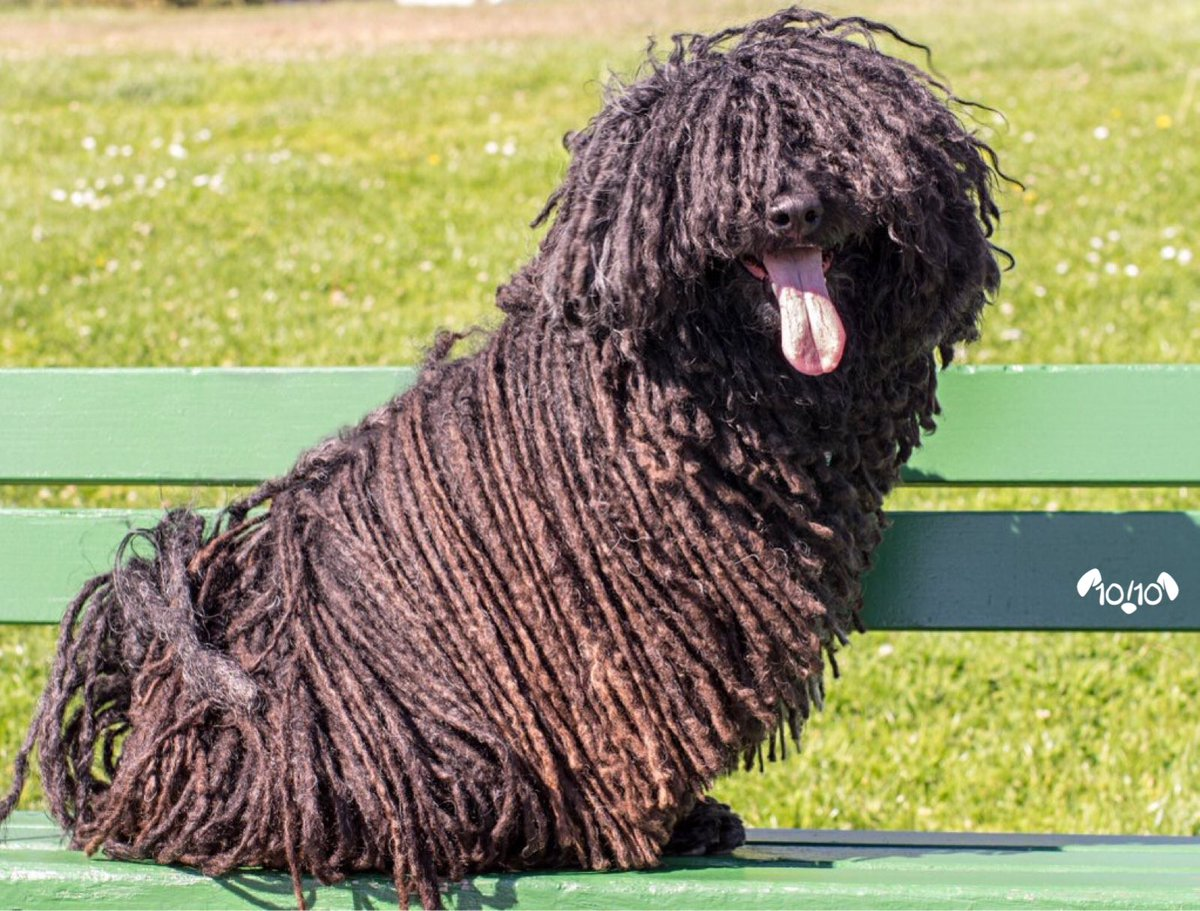

Dog name:  Remus
Dog breed:  komondor
prediction:  0.942856
rate:  11 / 10


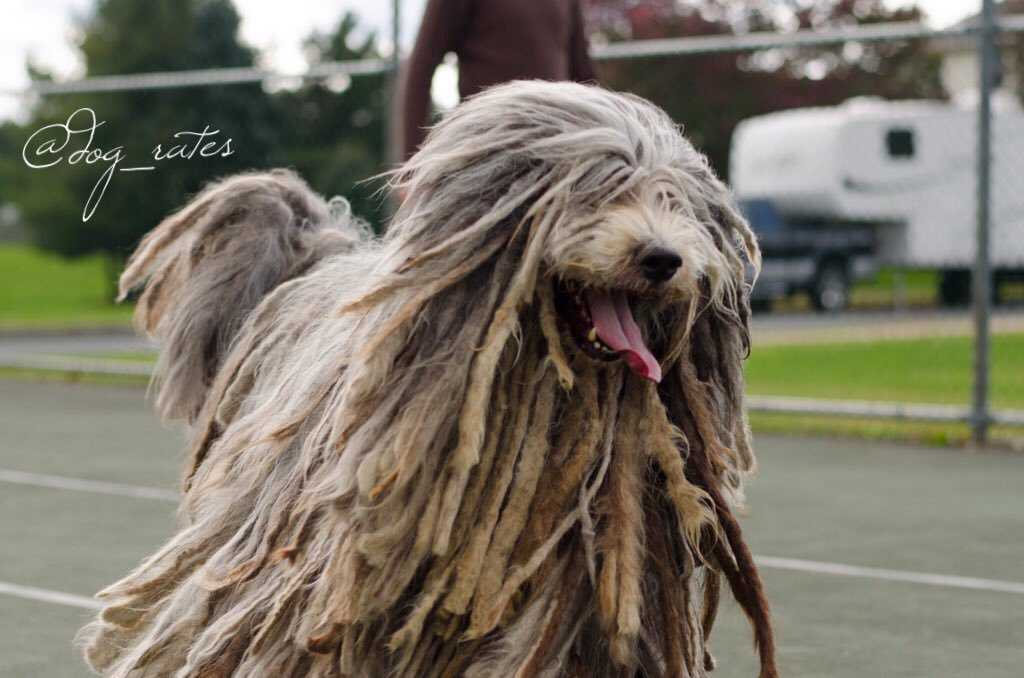

Dog name:  None
Dog breed:  komondor
prediction:  0.999956
rate:  10 / 10


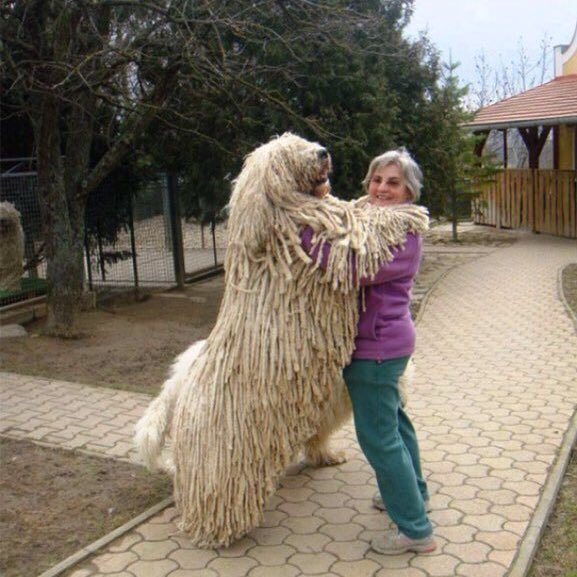

In [1655]:
for dog in range(df_best_predicted.shape[0]):
    dog_url = df_best_predicted['jpg_url'][dog]
    print('Dog name: ', df_best_predicted['name'][dog])
    print('Dog breed: ', df_best_predicted['p1'][dog])
    print('prediction: ', df_best_predicted['p1_conf'][dog])
    print('rate: ', df_best_predicted['rating_numerator'][dog], '/ 10')
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/best_predicted_breed_"+str(dog)+".jpg")

And here is the dog whose breed was best predicted: (also from the same breed as the best predicted breed)

In [1656]:
# best predicted dog 
df_best_predicted = df[df['p1_conf'] == df['p1_conf'].max()]
df_best_predicted = df_best_predicted.reset_index(drop=True)
df_best_predicted.shape

(1, 21)

Dog name:  None
Dog breed:  komondor
prediction:  0.999956
retweet:  496
favorite:  1040
rate:  10 / 10
text:  This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg


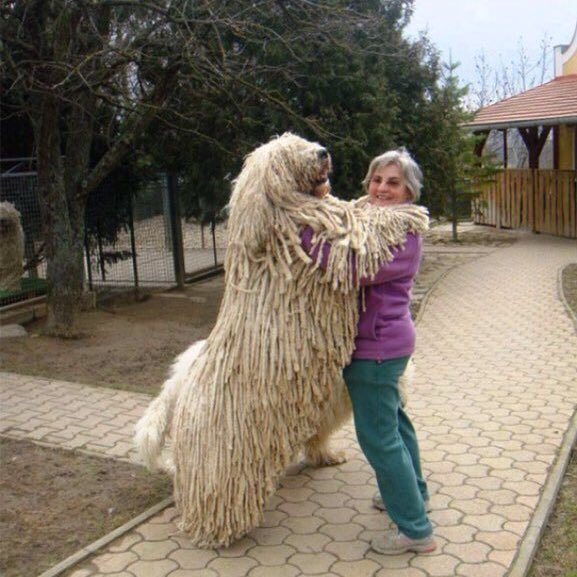

In [1659]:
for dog in range(df_best_predicted.shape[0]):
    dog_url = df_best_predicted['jpg_url'][dog]
    print('Dog name: ', df_best_predicted['name'][dog])
    print('Dog breed: ', df_best_predicted['p1'][dog])
    print('prediction: ', df_best_predicted['p1_conf'][dog])
    print('retweet: ', df_best_predicted['retweet_count'][dog])
    print('favorite: ', df_best_predicted['favorite_count'][dog])
    print('rate: ', df_best_predicted['rating_numerator'][dog], '/', df_best_predicted['rating_denominator'][dog])
    print('text: ', df_best_predicted['text'][dog])
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/best_predicted_breed_"+str(dog)+".jpg")

### Most rated dog breed
The 10 most rated dog breeds:

In [1660]:
df_stat.sort_values('count',ascending=False)[:10]

p1_conf  count
p1                                 
golden_retriever    0.728592    139
Labrador_retriever  0.649661     92
Pembroke            0.717223     88
Chihuahua           0.590874     77
pug                 0.759223     54
chow                0.615648     41
Samoyed             0.740719     39
Pomeranian          0.751073     37
toy_poodle          0.611089     37
malamute            0.589451     29

In [1661]:
df_most_rated = df[df['p1'] == 'golden_retriever']
df_most_rated = df_most_rated.reset_index(drop=True)
df_most_rated.shape

(139, 21)

Let's look at 10 dogs of the most rated breed in the dataset-the golden retriever:

Dog name:  Stuart
Dog breed:  golden_retriever
prediction rate:  0.953442
rate:  13 / 10
text:  This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq


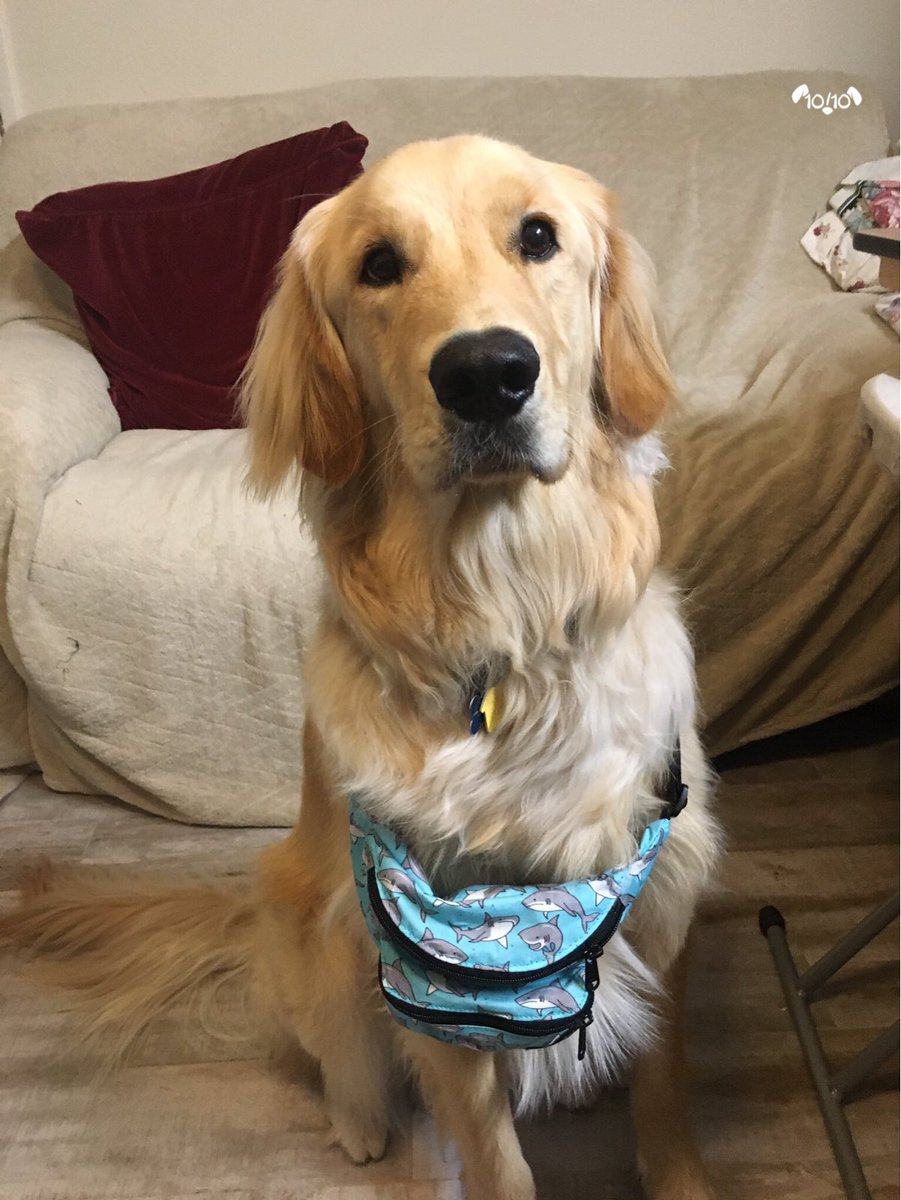

Dog name:  Jim
Dog breed:  golden_retriever
prediction rate:  0.714719
rate:  12 / 10
text:  This is Jim. He found a fren. Taught him how to sit like the good boys. 12/10 for both https://t.co/chxruIOUJN


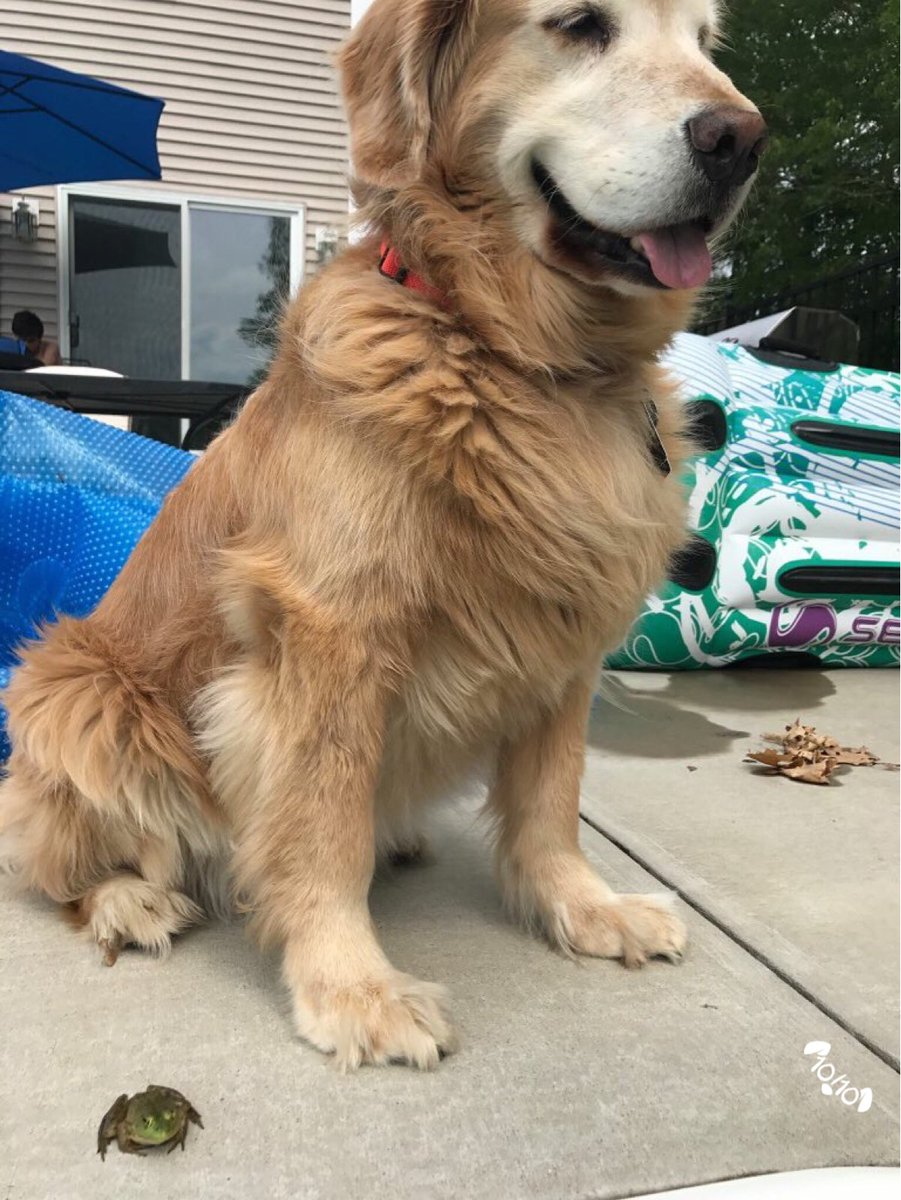

Dog name:  Zeke
Dog breed:  golden_retriever
prediction rate:  0.46976
rate:  13 / 10
text:  This is Zeke. He has a new stick. Very proud of it. Would like you to throw it for him without taking it. 13/10 would do my best https://t.co/HTQ77yNQ5K


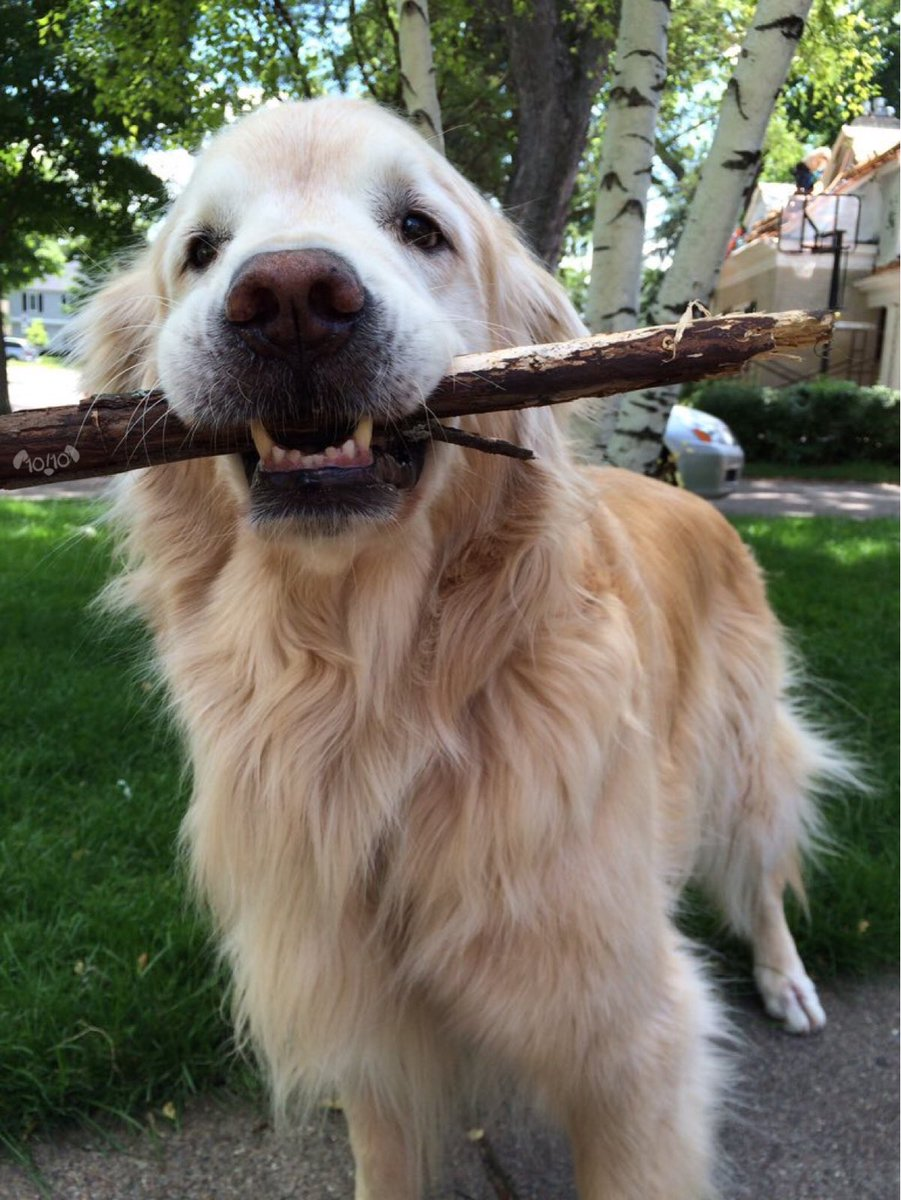

Dog name:  Bella
Dog breed:  golden_retriever
prediction rate:  0.943082
rate:  5 / 10
text:  This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948


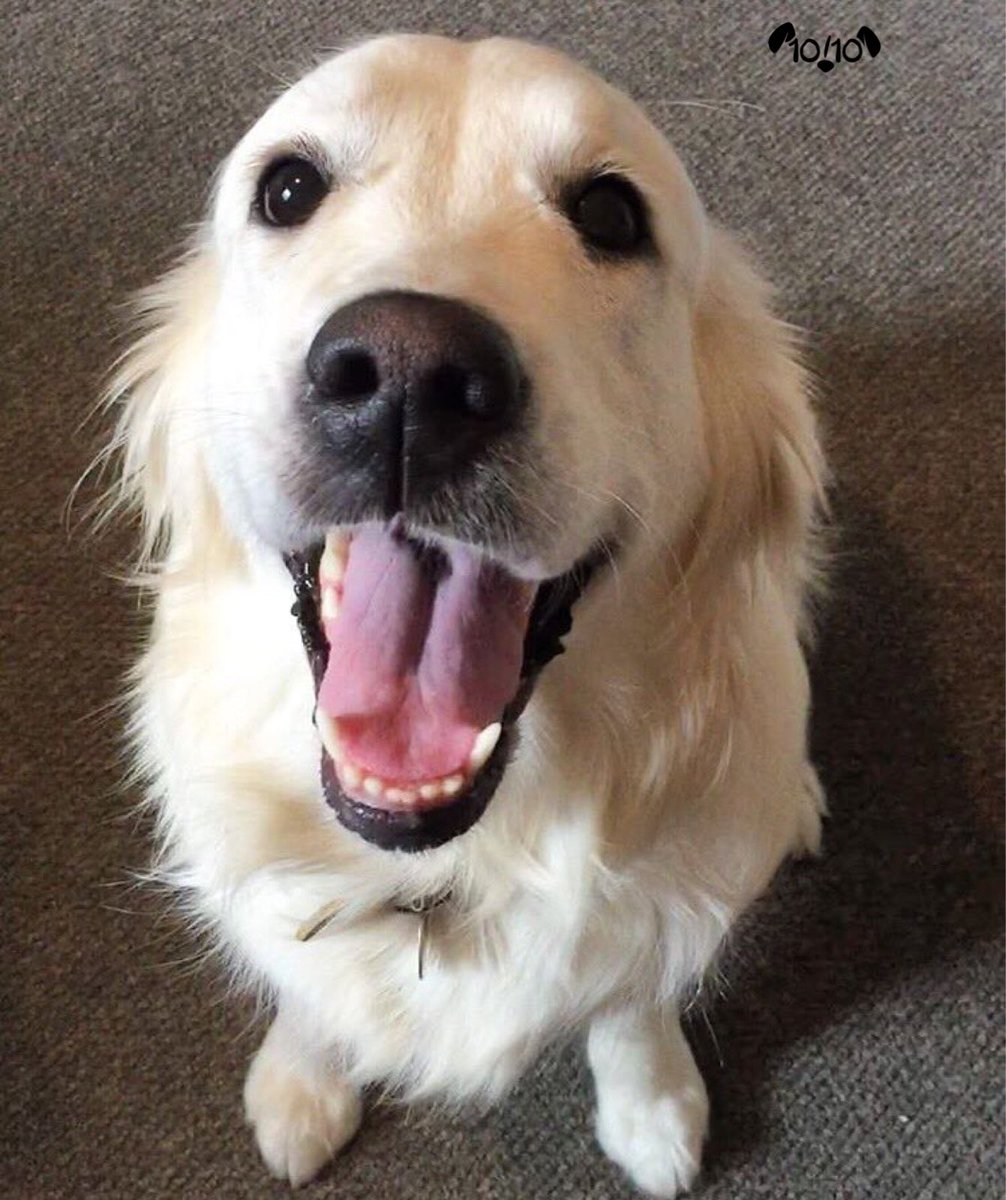

Dog name:  None
Dog breed:  golden_retriever
prediction rate:  0.949562
rate:  13 / 10
text:  Please only send dogs. We don't rate mechanics, no matter how h*ckin good. Thank you... 13/10 would sneak a pat https://t.co/Se5fZ9wp5E


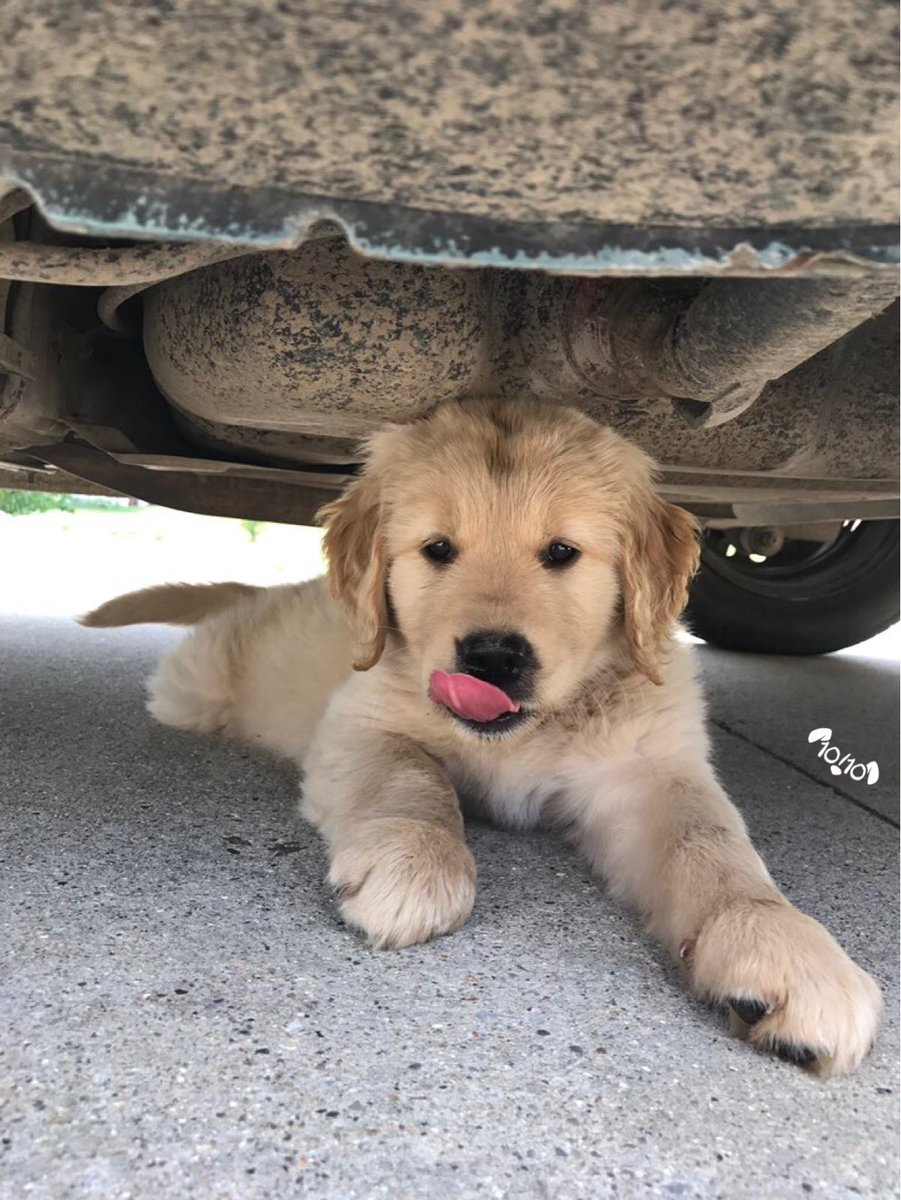

Dog name:  Alfy
Dog breed:  golden_retriever
prediction rate:  0.762211
rate:  13 / 10
text:  This is Alfy. You're witnessing his first watermelon experience. I think it was a success. 13/10 happy 4th Alfy 🇺🇸 https://t.co/fYP5RlutfA


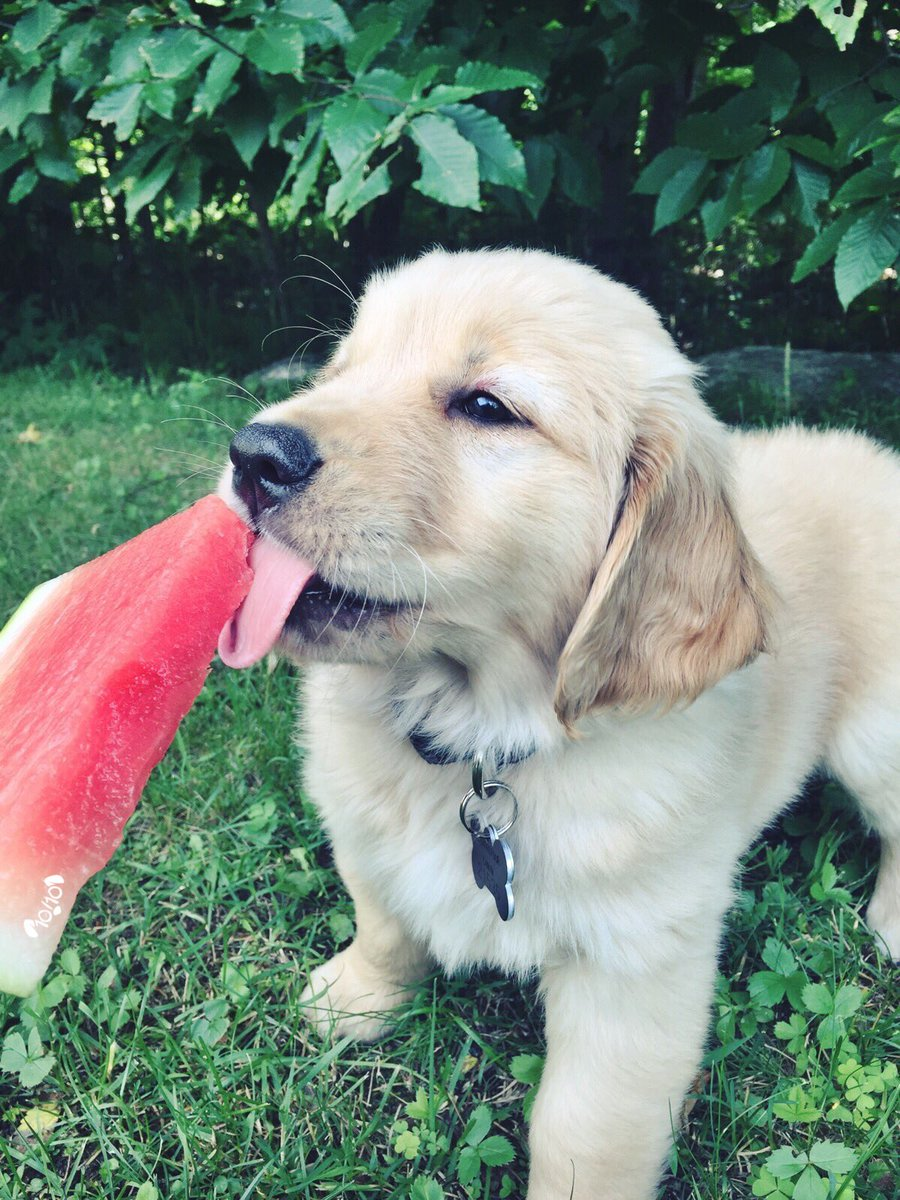

Dog name:  Bella
Dog breed:  golden_retriever
prediction rate:  0.913255
rate:  12 / 10
text:  This is Bella. She had her first beach experience this morning. Complete success. 12/10 would perform a sandy boop https://t.co/4VsFysDmiw


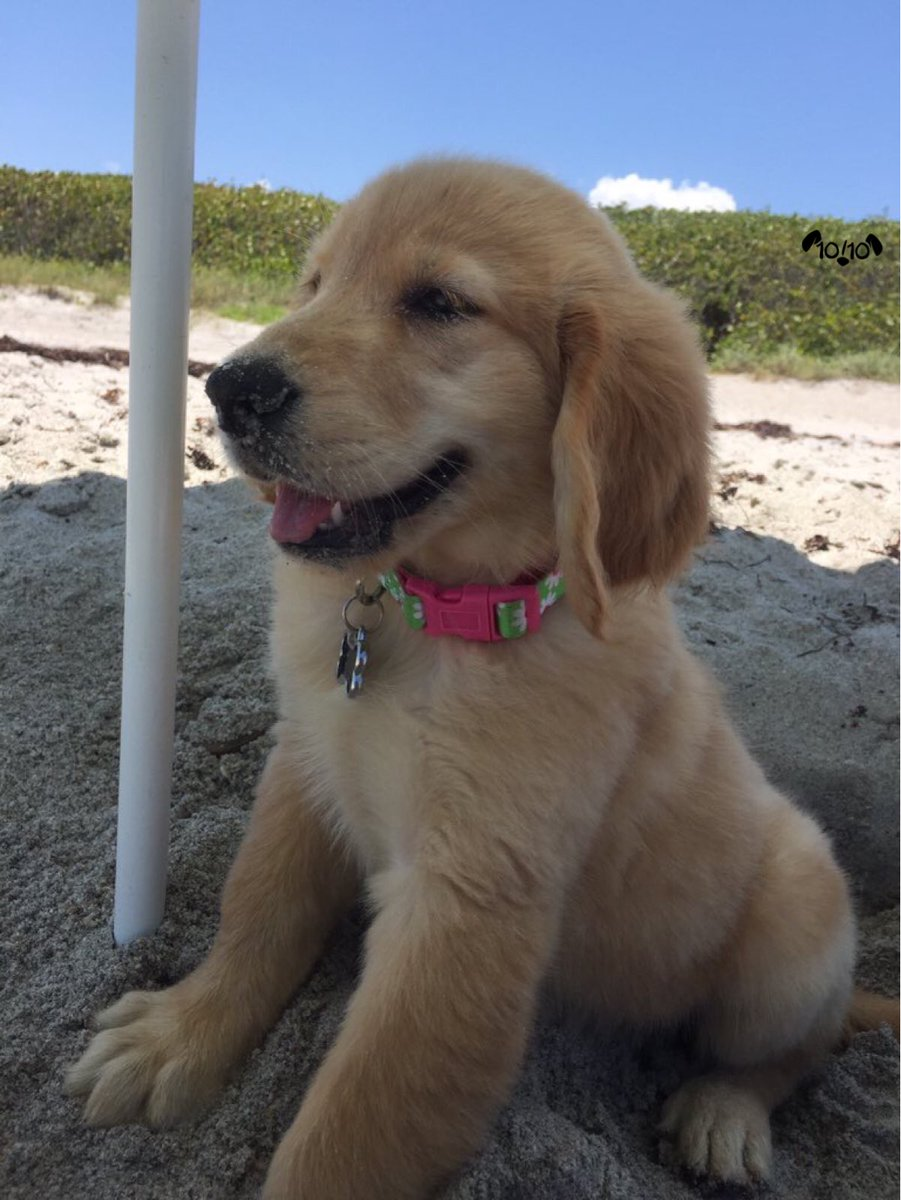

Dog name:  Benedict
Dog breed:  golden_retriever
prediction rate:  0.874566
rate:  13 / 10
text:  This is Benedict. He wants to thank you for this delightful urban walk. Hopes you know he loves you. 13/10 super duper good boy https://t.co/26BXueUgbs


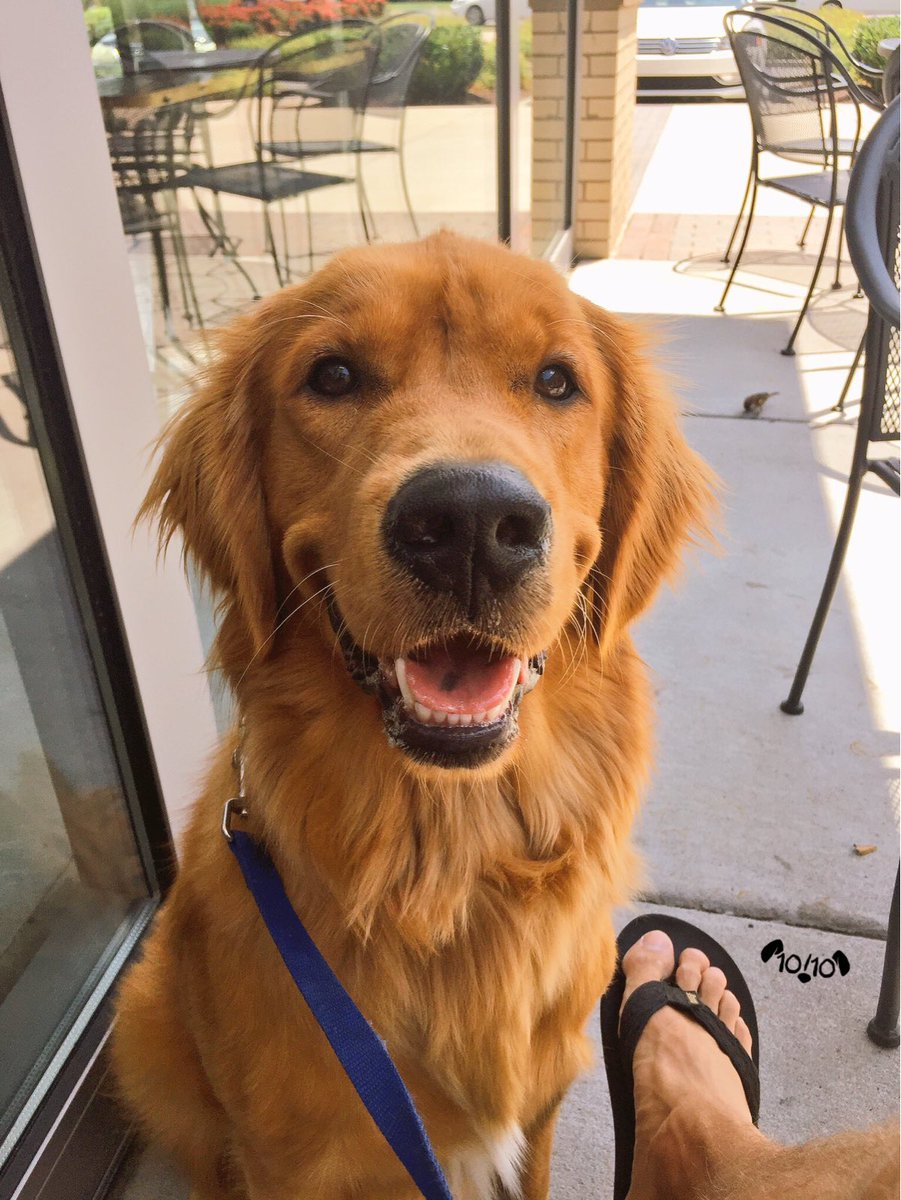

Dog name:  Zoey
Dog breed:  golden_retriever
prediction rate:  0.841001
rate:  13 / 10
text:  This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it. 13/10 https://t.co/T1xlgaPujm


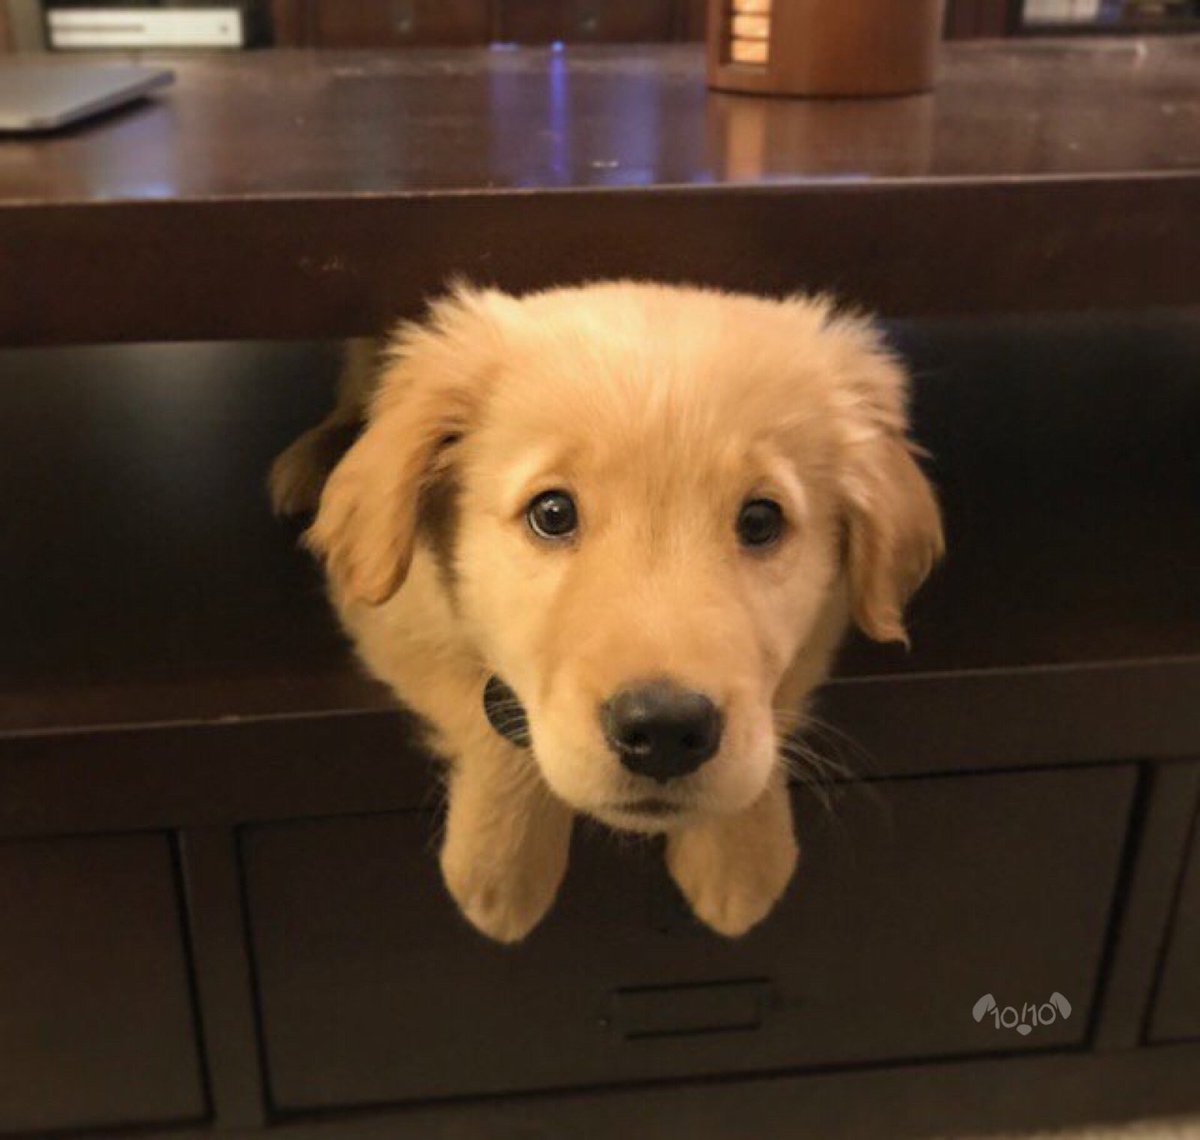

Dog name:  Boomer
Dog breed:  golden_retriever
prediction rate:  0.673664
rate:  13 / 10
text:  Meet Boomer. He's just checking pup on you. Hopes you had a good day. If not, he hopes he made it better. 13/10 extremely good boy https://t.co/pozUoHLkGg


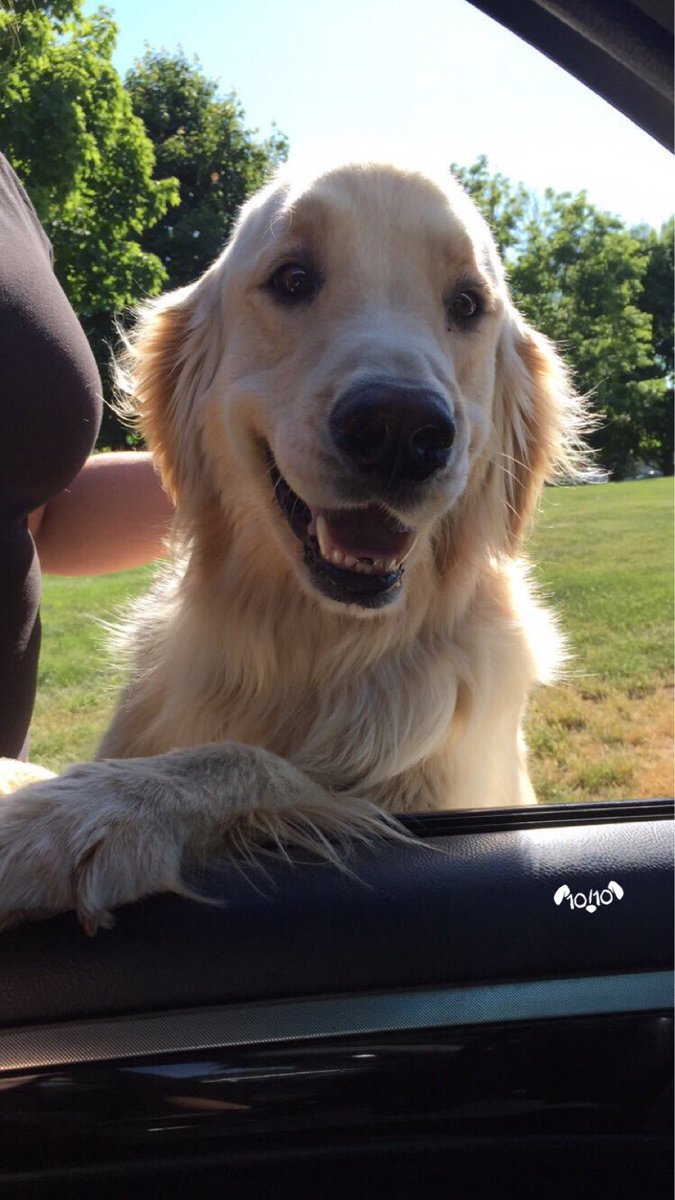

In [1662]:
# show only 10 of 139 dogs
for dog in range(10):
    dog_url = df_most_rated['jpg_url'][dog]
    print('Dog name: ', df_most_rated['name'][dog])
    print('Dog breed: ', df_most_rated['p1'][dog])
    print('prediction rate: ', df_most_rated['p1_conf'][dog])
    print('rate: ', df_most_rated['rating_numerator'][dog], '/', df_most_rated['rating_denominator'][dog])
    print('text: ', df_most_rated['text'][dog])
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/most_rated_breed"+str(dog)+".jpg")

### most favored dog
The most favored dog from twitter favorite counts:

In [1663]:
df_most_favorited = df[df['favorite_count'] == df['favorite_count'].max()]
df_most_favorited = df_most_favorited.reset_index(drop=True)
df_most_favorited.shape

(1, 21)

Dog name:  None
Dog breed:  Labrador_retriever
favorited:  162409
prediction rate:  0.825333
retweet:  82576
favorite:  162409
rate:  13 / 10
text:  Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4


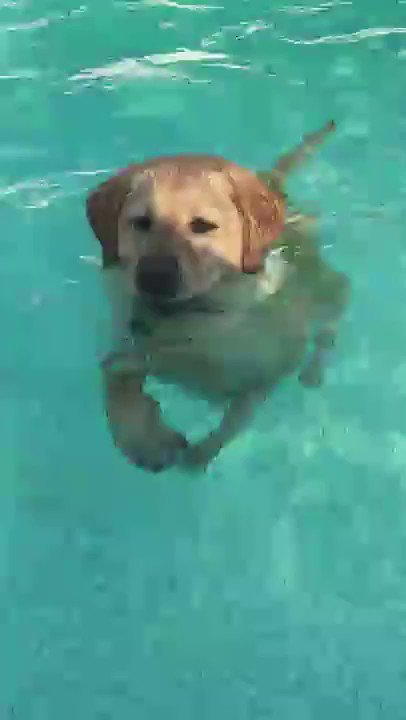

In [1664]:
for dog in range(df_most_favorited.shape[0]):
    dog_url = df_most_favorited['jpg_url'][dog]
    print('Dog name: ', df_most_favorited['name'][dog])
    print('Dog breed: ', df_most_favorited['p1'][dog])
    print('favorited: ', df_most_favorited['favorite_count'][dog])
    print('prediction rate: ', df_most_favorited['p1_conf'][dog])
    print('retweet: ', df_most_favorited['retweet_count'][dog])
    print('favorite: ', df_most_favorited['favorite_count'][dog])
    print('rate: ', df_most_favorited['rating_numerator'][dog], '/', df_most_rated['rating_denominator'][dog])
    print('text: ', df_most_favorited['text'][dog])
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/df_most_favorited_"+str(dog)+".jpg")

How close are the other dogs with their favorite counts? Therefore we look at the histogram of the favorite counts:

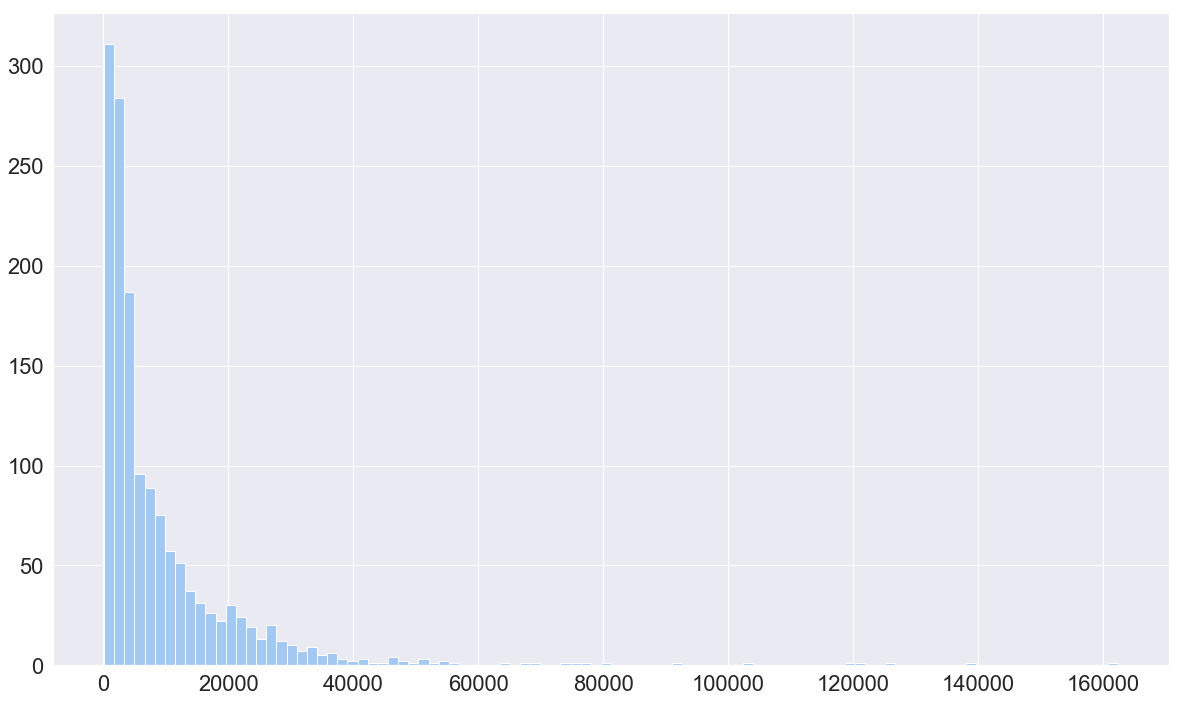

In [1665]:
df['favorite_count'].hist(bins=100)

### most retweeted dog

Who is the most retweeded dog?

In [1666]:
df_most_retweeted = df[df['retweet_count'] == df['retweet_count'].max()]
df_most_retweeted = df_most_retweeted.reset_index(drop=True)
df_most_retweeted.shape

(1, 21)

Dog name:  None
Dog breed:  Labrador_retriever
favorited:  162409
rate:  13 / 10


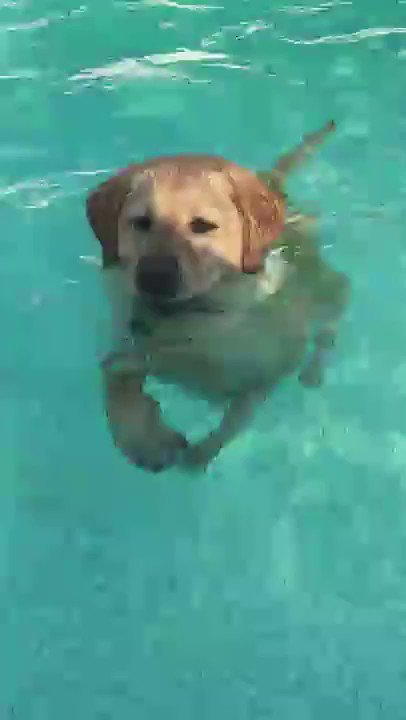

In [1667]:
for dog in range(df_most_retweeted.shape[0]):
    dog_url = df_most_retweeted['jpg_url'][dog]
    print('Dog name: ', df_most_retweeted['name'][dog])
    print('Dog breed: ', df_most_retweeted['p1'][dog])
    print('favorited: ', df_most_retweeted['favorite_count'][dog])
    print('rate: ', df_most_retweeted['rating_numerator'][dog], '/ 10')
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/df_most_retweeted_"+str(dog)+".jpg")

### Visualization

In [1668]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,12)})
sns.set(font_scale=2.0)
sns.set_palette("pastel")

### Used dog vocabularies

In [1671]:
df['dog_stage'].value_counts()

pupper     150
doggo       57
puppo       20
floofer      8
Name: dog_stage, dtype: int64

### Ratings over time (colored by retweet count)

In [1672]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

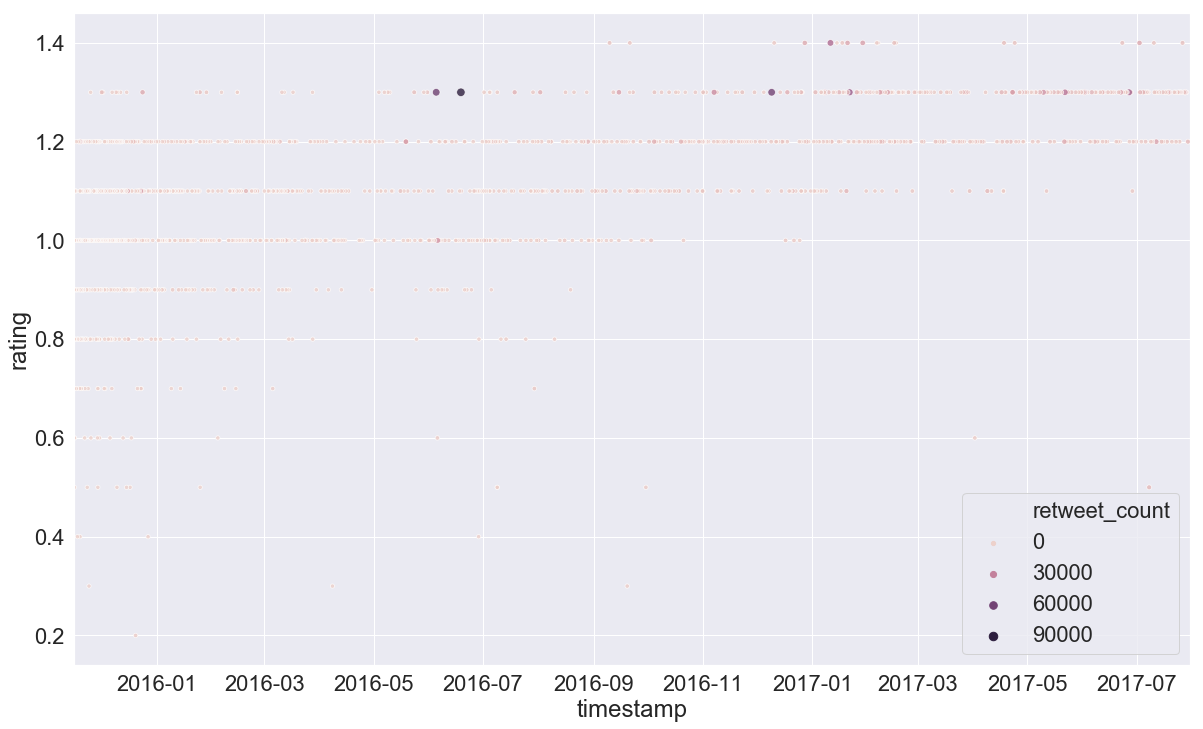

In [1677]:
ax = sns.scatterplot(x="timestamp", y="rating",
                      hue="retweet_count", size="retweet_count",alpha=.8,
                      data=df)

ax.set_xlim(df['timestamp'].min(), df['timestamp'].max())
fig = ax.get_figure()
fig.savefig("plots/retweet_rating_over_time_b.png")

The ratings have changed over time. The ratings have increased.

### Ratings over time (colored by favorite count)

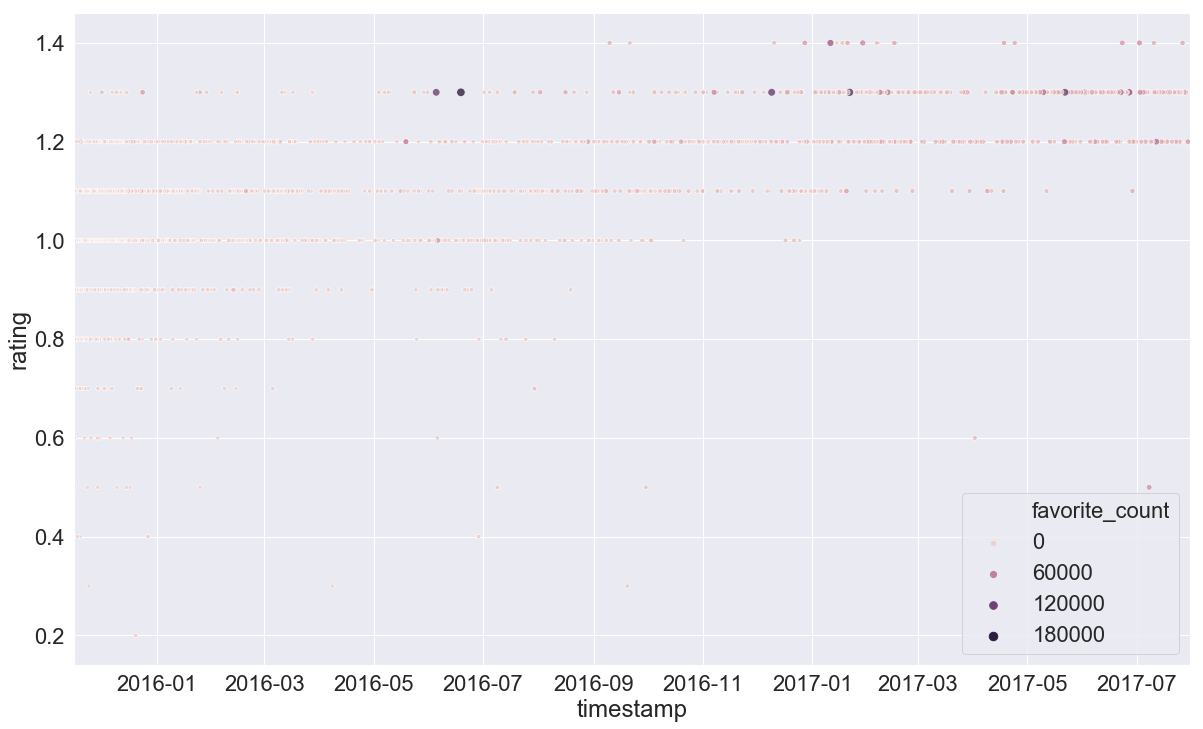

In [1678]:
ax = sns.scatterplot(x="timestamp", y="rating",
                      hue="favorite_count", size="favorite_count",alpha=.8,
                      data=df)

ax.set_xlim(df['timestamp'].min(), df['timestamp'].max())
fig = ax.get_figure()
fig.savefig("plots/favorit_rating_over_time_b.png")

If we look at the favorite count and the retweet count in the diagrams above, then we can see, that they might be similar.

### Retweet and Favorite correlation

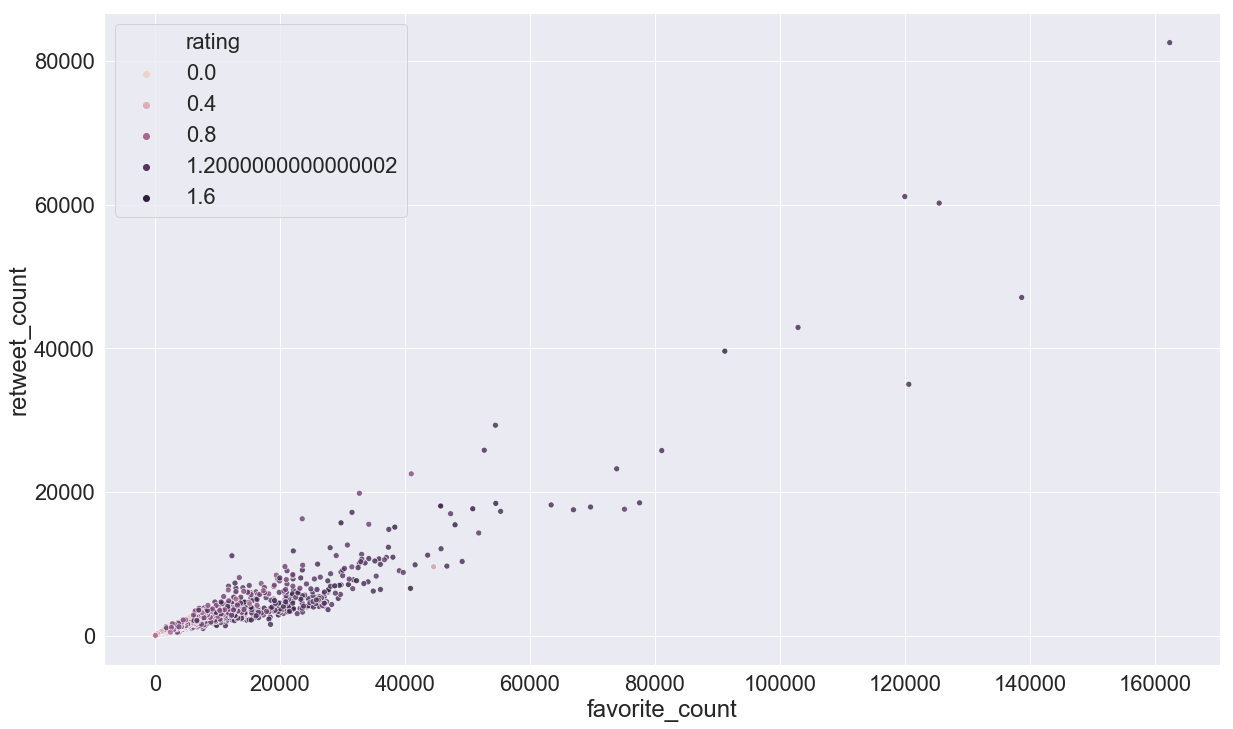

In [1679]:
ax = sns.scatterplot(x="favorite_count", y="retweet_count",hue="rating", 
                     alpha=.8,
                    data=df)
fig = ax.get_figure()
fig.savefig("plots/retweet_favorit_scatter_b.png")

The retweet and favorite count correlate.

### Retweet count over Rating (colored by favorite count)

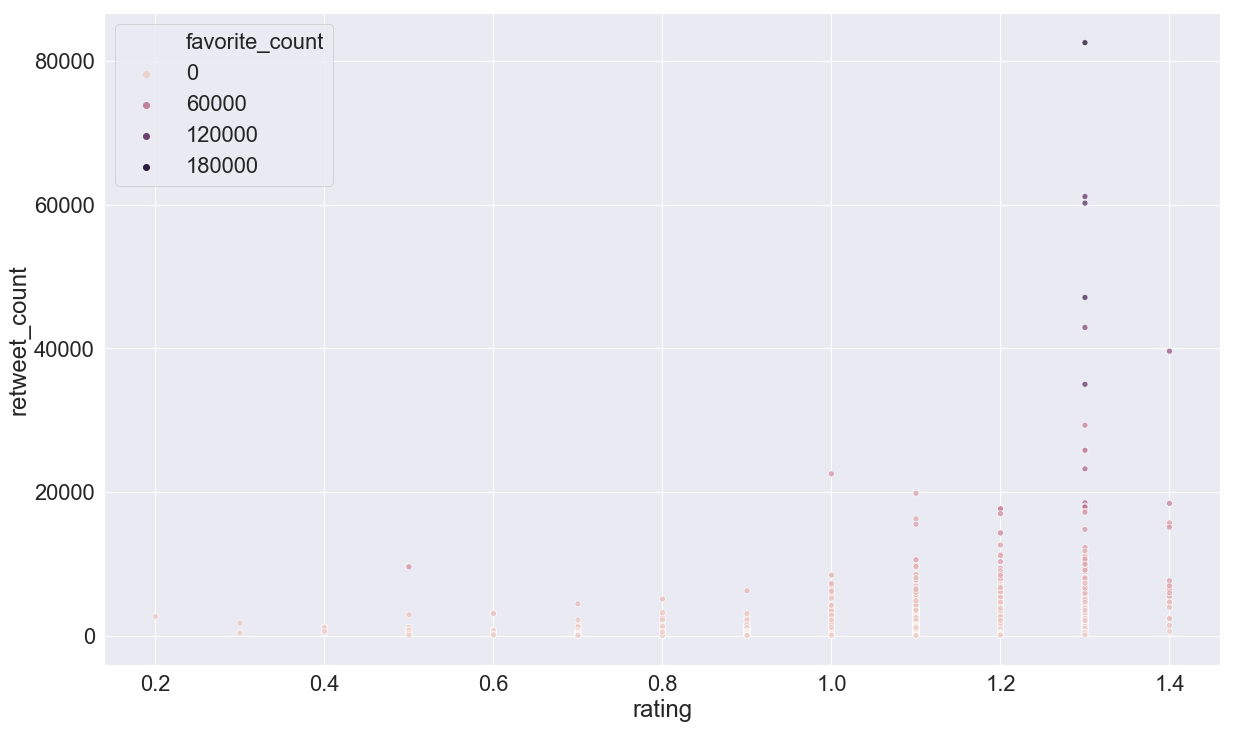

In [1680]:
ax = sns.scatterplot(x="rating", y="retweet_count",hue="favorite_count", 
                     alpha=.8,
                    data=df)
fig = ax.get_figure()
fig.savefig("plots/retweet_rating_scatter_b.png")

The low rating values are not retweeted well. The higher rating values (x-axis) are retweeted more often (y-axis). And also favored more often (color).

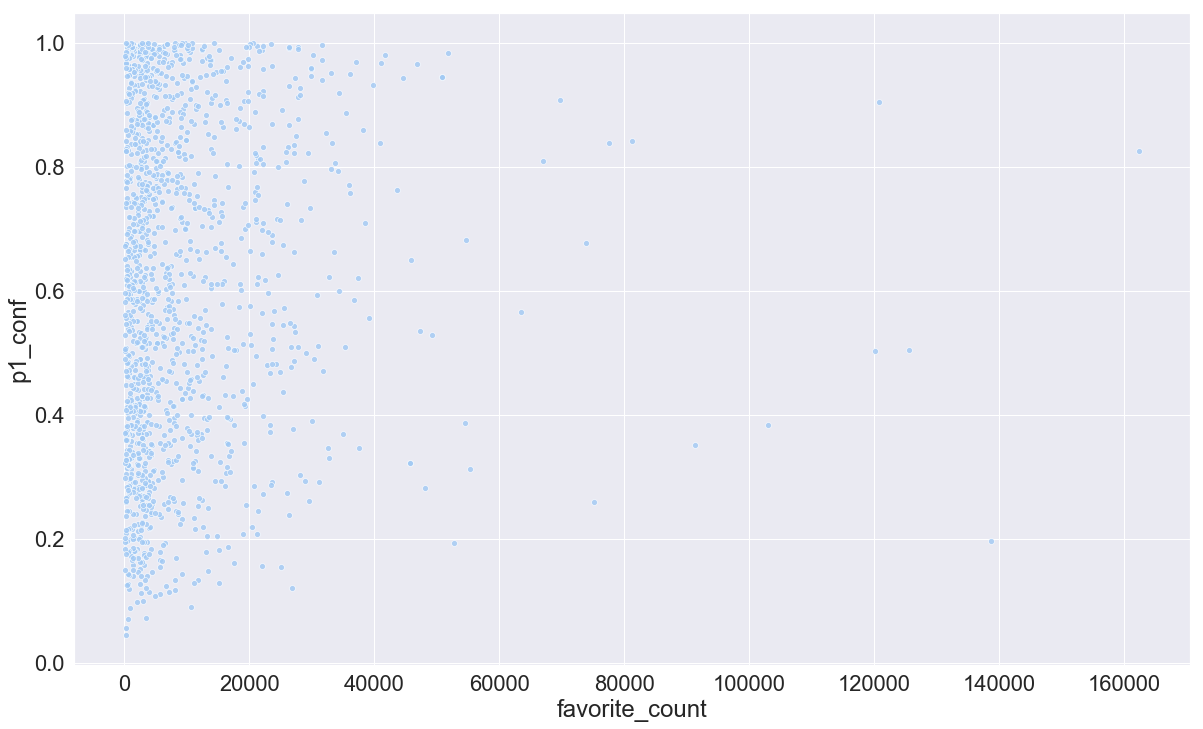

In [1681]:
ax = sns.scatterplot(x="favorite_count", y="p1_conf", 
                     alpha=.8,
                    data=df)
fig = ax.get_figure()
fig.savefig("plots/favorite_p1conf_scatter.png")

There is no correlatin between the prediction confidence of the neural network and the favorite count.